# NEURAL NETWORK IMPLEMENTATION

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
#import warnings
#warnings.filterwarnings(action='ignore')

## Loading the cleaned and filled dataset

In [2]:
df = pd.read_csv('final_project_cleaned.csv')

In [3]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
13079,Can you tell me what the disposable cards are ...,card_queries_or_issues
13080,The ATM won't give me my card back. I need it ...,card_queries_or_issues
13081,Can you please tell me why my card payments ar...,card_queries_or_issues
13082,The rate for a currency exchange was wrong whe...,needs_troubleshooting


## PREPROCESSING AND PADDING

In [4]:
# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

## DEFINE THE NEURAL NETWORK MODELS WITH DEFAULT PARAMS PASSED 

In [5]:
# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## OVERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)



#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

## RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
383/383 [==============================] - 15s 35ms/step - loss: 0.3457 - accuracy: 0.6764 - val_loss: 0.1748 - val_accuracy: 0.8681
Epoch 2/10
383/383 [==============================] - 15s 40ms/step - loss: 0.1550 - accuracy: 0.8825 - val_loss: 0.0913 - val_accuracy: 0.9351
Epoch 3/10
383/383 [==============================] - 15s 40ms/step - loss: 0.1105 - accuracy: 0.9201 - val_loss: 0.0531 - val_accuracy: 0.9599
Epoch 4/10
383/383 [==============================] - 16s 41ms/step - loss: 0.0949 - accuracy: 0.9313 - val_loss: 0.0666 - val_accuracy: 0.9530
Epoch 5/10
383/383 [==============================] - 17s 44ms/step - loss: 0.0758 - accuracy: 0.9452 - val_loss: 0.0432 - val_accuracy: 0.9723
Epoch 6/10
383/383 [==============================] - 17s 44ms/step - loss: 0.0610 - accuracy: 0.9580 - val_loss: 0.0281 - val_accuracy: 0.9801
Epoch 7/10
383/383 [==============================] - 17s 44ms/step - loss: 0.0669 - accuracy: 0.9509 - val_loss: 

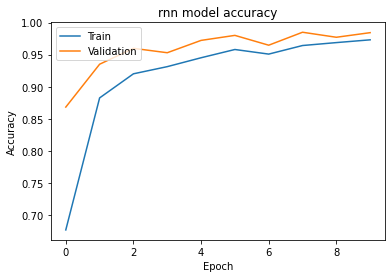

Training cnn model...
Epoch 1/10
383/383 [==============================] - 15s 37ms/step - loss: 0.3734 - accuracy: 0.6470 - val_loss: 0.1931 - val_accuracy: 0.8623
Epoch 2/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1414 - accuracy: 0.8976 - val_loss: 0.0898 - val_accuracy: 0.9393
Epoch 3/10
383/383 [==============================] - 15s 38ms/step - loss: 0.0982 - accuracy: 0.9301 - val_loss: 0.0534 - val_accuracy: 0.9680
Epoch 4/10
383/383 [==============================] - 14s 38ms/step - loss: 0.0714 - accuracy: 0.9522 - val_loss: 0.0487 - val_accuracy: 0.9644
Epoch 5/10
383/383 [==============================] - 16s 42ms/step - loss: 0.0564 - accuracy: 0.9634 - val_loss: 0.0315 - val_accuracy: 0.9814
Epoch 6/10
383/383 [==============================] - 15s 40ms/step - loss: 0.0438 - accuracy: 0.9710 - val_loss: 0.0254 - val_accuracy: 0.9827
Epoch 7/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0362 - accuracy: 0.9779 - val_loss: 

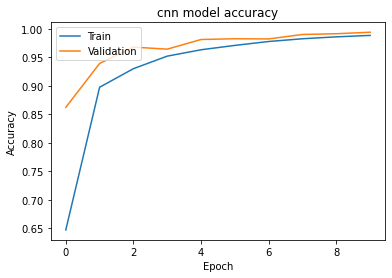

Training lstm model...
Epoch 1/10
383/383 [==============================] - 40s 97ms/step - loss: 0.3250 - accuracy: 0.7024 - val_loss: 0.1315 - val_accuracy: 0.9207
Epoch 2/10
383/383 [==============================] - 34s 90ms/step - loss: 0.1434 - accuracy: 0.8926 - val_loss: 0.0900 - val_accuracy: 0.9396
Epoch 3/10
383/383 [==============================] - 36s 93ms/step - loss: 0.1098 - accuracy: 0.9213 - val_loss: 0.0627 - val_accuracy: 0.9592
Epoch 4/10
383/383 [==============================] - 35s 92ms/step - loss: 0.0923 - accuracy: 0.9352 - val_loss: 0.0585 - val_accuracy: 0.9592
Epoch 5/10
383/383 [==============================] - 34s 89ms/step - loss: 0.0771 - accuracy: 0.9492 - val_loss: 0.0422 - val_accuracy: 0.9690
Epoch 6/10
383/383 [==============================] - 35s 90ms/step - loss: 0.0704 - accuracy: 0.9523 - val_loss: 0.0450 - val_accuracy: 0.9657
Epoch 7/10
383/383 [==============================] - 38s 99ms/step - loss: 0.0619 - accuracy: 0.9600 - val_loss:

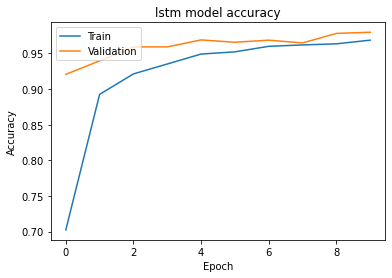

Training bilstm model...
Epoch 1/10
383/383 [==============================] - 53s 128ms/step - loss: 0.3220 - accuracy: 0.7074 - val_loss: 0.1025 - val_accuracy: 0.9289
Epoch 2/10
383/383 [==============================] - 51s 133ms/step - loss: 0.1442 - accuracy: 0.8948 - val_loss: 0.0792 - val_accuracy: 0.9409
Epoch 3/10
383/383 [==============================] - 52s 137ms/step - loss: 0.1147 - accuracy: 0.9166 - val_loss: 0.0624 - val_accuracy: 0.9618
Epoch 4/10
383/383 [==============================] - 47s 123ms/step - loss: 0.0912 - accuracy: 0.9349 - val_loss: 0.0625 - val_accuracy: 0.9576
Epoch 5/10
383/383 [==============================] - 49s 128ms/step - loss: 0.0804 - accuracy: 0.9428 - val_loss: 0.0494 - val_accuracy: 0.9680
Epoch 6/10
383/383 [==============================] - 47s 124ms/step - loss: 0.0720 - accuracy: 0.9500 - val_loss: 0.0473 - val_accuracy: 0.9683
Epoch 7/10
383/383 [==============================] - 48s 126ms/step - loss: 0.0621 - accuracy: 0.9572 - 

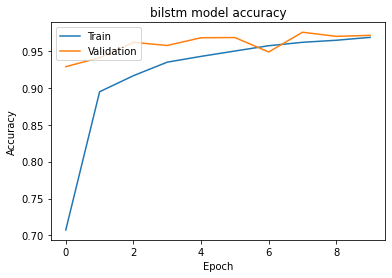

In [7]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [8]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)



#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

## RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
132/132 [==============================] - 7s 44ms/step - loss: 0.4686 - accuracy: 0.5244 - val_loss: 0.9045 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 6s 46ms/step - loss: 0.2811 - accuracy: 0.7658 - val_loss: 0.6719 - val_accuracy: 0.3720
Epoch 3/10
132/132 [==============================] - 6s 46ms/step - loss: 0.1757 - accuracy: 0.8650 - val_loss: 0.3307 - val_accuracy: 0.7374
Epoch 4/10
132/132 [==============================] - 6s 48ms/step - loss: 0.1270 - accuracy: 0.9062 - val_loss: 0.4794 - val_accuracy: 0.6375
Epoch 5/10
132/132 [==============================] - 7s 53ms/step - loss: 0.0995 - accuracy: 0.9303 - val_loss: 0.2373 - val_accuracy: 0.8278
Epoch 6/10
132/132 [==============================] - 7s 51ms/step - loss: 0.0778 - accuracy: 0.9431 - val_loss: 0.2722 - val_accuracy: 0.8097
Epoch 7/10
132/132 [==============================] - 7s 52ms/step - loss: 0.0558 - accuracy: 0.9619 - val_loss: 0.3

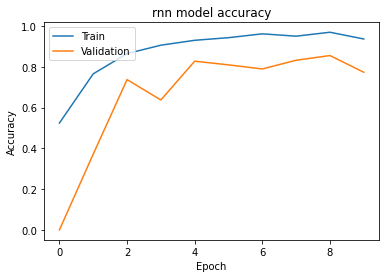

Training cnn model...
Epoch 1/10
132/132 [==============================] - 6s 40ms/step - loss: 0.4891 - accuracy: 0.4704 - val_loss: 0.9285 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 5s 38ms/step - loss: 0.3057 - accuracy: 0.7524 - val_loss: 0.8612 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 5s 38ms/step - loss: 0.2088 - accuracy: 0.8298 - val_loss: 0.7394 - val_accuracy: 0.0533
Epoch 4/10
132/132 [==============================] - 5s 38ms/step - loss: 0.1421 - accuracy: 0.8917 - val_loss: 0.3358 - val_accuracy: 0.7593
Epoch 5/10
132/132 [==============================] - 5s 38ms/step - loss: 0.0898 - accuracy: 0.9429 - val_loss: 0.3719 - val_accuracy: 0.7612
Epoch 6/10
132/132 [==============================] - 5s 38ms/step - loss: 0.0664 - accuracy: 0.9574 - val_loss: 0.2765 - val_accuracy: 0.8268
Epoch 7/10
132/132 [==============================] - 5s 39ms/step - loss: 0.0507 - accuracy: 0.9707 - val_loss:

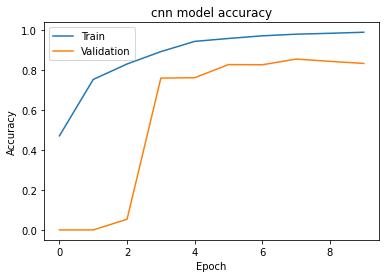

Training lstm model...
Epoch 1/10
132/132 [==============================] - 15s 97ms/step - loss: 0.5018 - accuracy: 0.4656 - val_loss: 0.8704 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 12s 91ms/step - loss: 0.2701 - accuracy: 0.7900 - val_loss: 0.5822 - val_accuracy: 0.4339
Epoch 3/10
132/132 [==============================] - 12s 95ms/step - loss: 0.1743 - accuracy: 0.8767 - val_loss: 0.2368 - val_accuracy: 0.8316
Epoch 4/10
132/132 [==============================] - 13s 95ms/step - loss: 0.1285 - accuracy: 0.9060 - val_loss: 0.2632 - val_accuracy: 0.8230
Epoch 5/10
132/132 [==============================] - 12s 89ms/step - loss: 0.1045 - accuracy: 0.9241 - val_loss: 0.2922 - val_accuracy: 0.8164
Epoch 6/10
132/132 [==============================] - 13s 95ms/step - loss: 0.0902 - accuracy: 0.9369 - val_loss: 0.2154 - val_accuracy: 0.8649
Epoch 7/10
132/132 [==============================] - 12s 89ms/step - loss: 0.0802 - accuracy: 0.9441 - val_l

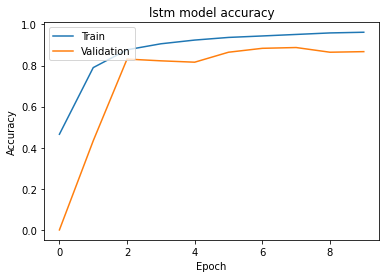

Training bilstm model...
Epoch 1/10
132/132 [==============================] - 21s 129ms/step - loss: 0.4826 - accuracy: 0.4816 - val_loss: 0.9601 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 17s 127ms/step - loss: 0.2641 - accuracy: 0.7927 - val_loss: 0.6987 - val_accuracy: 0.2236
Epoch 3/10
132/132 [==============================] - 16s 122ms/step - loss: 0.1755 - accuracy: 0.8736 - val_loss: 0.3441 - val_accuracy: 0.7383
Epoch 4/10
132/132 [==============================] - 17s 125ms/step - loss: 0.1328 - accuracy: 0.9062 - val_loss: 0.1991 - val_accuracy: 0.8744
Epoch 5/10
132/132 [==============================] - 16s 122ms/step - loss: 0.1058 - accuracy: 0.9269 - val_loss: 0.2347 - val_accuracy: 0.8468
Epoch 6/10
132/132 [==============================] - 16s 122ms/step - loss: 0.0920 - accuracy: 0.9353 - val_loss: 0.2002 - val_accuracy: 0.8725
Epoch 7/10
132/132 [==============================] - 16s 122ms/step - loss: 0.0833 - accuracy: 0.941

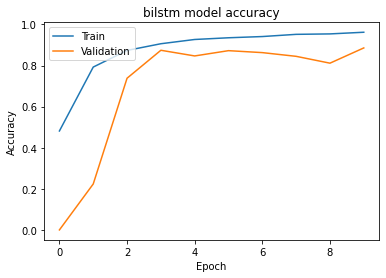

In [9]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## FINDING BEST PARAMS FOR OVERSAMPLED DATA

In [10]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)



#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [11]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\1669981765.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5
320/320 [==============================] - 11s 30ms/step - loss: 0.3782 - accuracy: 0.6397
Epoch 2/5
320/320 [==============================] - 10s 30ms/step - loss: 0.1601 - accuracy: 0.8848
Epoch 3/5
320/320 [==============================] - 10s 32ms/step - loss: 0.1079 - accuracy: 0.9263
Epoch 4/5
320/320 [==============================] - 10s 32ms/step - loss: 0.0878 - accuracy: 0.9420
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.1824 - accuracy: 0.8674
Epoch 1/5
320/320 [==============================] - 13s 32ms/step - loss: 0.3836 - accuracy: 0.6152
Epoch 2/5
320/320 [==============================] - 10s 32ms/step - loss: 0.1985 - accuracy: 0.8387
Epoch 3/5
320/320 [==============================] - 11s 35ms/step - loss: 0.1356 - accuracy: 0.9032
Epoch 4/5
320/320 [==============================] - 10s 32ms/step - loss: 0.0983 - accuracy: 0.9323
Epoch 5/5
160/160 [=============

160/160 [==============================] - 2s 7ms/step - loss: 0.1746 - accuracy: 0.8738
Epoch 1/5
320/320 [==============================] - 16s 44ms/step - loss: 0.3921 - accuracy: 0.6232
Epoch 2/5
320/320 [==============================] - 14s 44ms/step - loss: 0.1747 - accuracy: 0.8715
Epoch 3/5
320/320 [==============================] - 14s 43ms/step - loss: 0.1336 - accuracy: 0.9012
Epoch 4/5
320/320 [==============================] - 14s 44ms/step - loss: 0.1075 - accuracy: 0.9224
Epoch 5/5
160/160 [==============================] - 1s 8ms/step - loss: 0.0589 - accuracy: 0.9602
Epoch 1/5
320/320 [==============================] - 16s 46ms/step - loss: 0.3182 - accuracy: 0.7103
Epoch 2/5
320/320 [==============================] - 14s 44ms/step - loss: 0.1303 - accuracy: 0.9059
Epoch 3/5
320/320 [==============================] - 14s 44ms/step - loss: 0.1170 - accuracy: 0.9143
Epoch 4/5
320/320 [==============================] - 15s 46ms/step - loss: 0.0790 - accuracy: 0.9457
Epoc

320/320 [==============================] - 11s 34ms/step - loss: 0.1295 - accuracy: 0.9070
Epoch 4/5
320/320 [==============================] - 11s 34ms/step - loss: 0.1088 - accuracy: 0.9257
Epoch 5/5
160/160 [==============================] - 2s 9ms/step - loss: 0.1712 - accuracy: 0.8698
Epoch 1/5
320/320 [==============================] - 12s 33ms/step - loss: 0.4347 - accuracy: 0.5566
Epoch 2/5
320/320 [==============================] - 10s 33ms/step - loss: 0.1823 - accuracy: 0.8674
Epoch 3/5
320/320 [==============================] - 10s 32ms/step - loss: 0.1192 - accuracy: 0.9185
Epoch 4/5
320/320 [==============================] - 11s 34ms/step - loss: 0.0872 - accuracy: 0.9428
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1821 - accuracy: 0.8672
Epoch 1/5
320/320 [==============================] - 12s 31ms/step - loss: 0.4096 - accuracy: 0.6080
Epoch 2/5
320/320 [==============================] - 11s 34ms/step - loss: 0.2050 - accuracy: 0.8488
Epoc

320/320 [==============================] - 16s 45ms/step - loss: 0.3855 - accuracy: 0.6287
Epoch 2/5
320/320 [==============================] - 15s 46ms/step - loss: 0.1868 - accuracy: 0.8648
Epoch 3/5
320/320 [==============================] - 15s 45ms/step - loss: 0.1372 - accuracy: 0.9018
Epoch 4/5
320/320 [==============================] - 14s 45ms/step - loss: 0.1136 - accuracy: 0.9222
Epoch 5/5
160/160 [==============================] - 2s 8ms/step - loss: 0.0557 - accuracy: 0.9602
Epoch 1/5
320/320 [==============================] - 24s 68ms/step - loss: 0.3773 - accuracy: 0.6520
Epoch 2/5
320/320 [==============================] - 22s 69ms/step - loss: 0.1522 - accuracy: 0.8951
Epoch 3/5
320/320 [==============================] - 22s 70ms/step - loss: 0.1101 - accuracy: 0.9237
Epoch 4/5
320/320 [==============================] - 22s 70ms/step - loss: 0.0880 - accuracy: 0.9416
Epoch 5/5
160/160 [==============================] - 2s 7ms/step - loss: 0.1753 - accuracy: 0.8768
Epoc

160/160 [==============================] - 1s 5ms/step - loss: 0.2056 - accuracy: 0.8472
Epoch 1/5
320/320 [==============================] - 18s 47ms/step - loss: 0.3610 - accuracy: 0.6543
Epoch 2/5
320/320 [==============================] - 14s 45ms/step - loss: 0.1592 - accuracy: 0.8833
Epoch 3/5
320/320 [==============================] - 16s 49ms/step - loss: 0.1122 - accuracy: 0.9184
Epoch 4/5
320/320 [==============================] - 15s 47ms/step - loss: 0.0893 - accuracy: 0.9374
Epoch 5/5
160/160 [==============================] - 2s 8ms/step - loss: 0.1912 - accuracy: 0.8609
Epoch 1/5
320/320 [==============================] - 16s 47ms/step - loss: 0.4127 - accuracy: 0.6027
Epoch 2/5
320/320 [==============================] - 15s 47ms/step - loss: 0.1924 - accuracy: 0.8580
Epoch 3/5
320/320 [==============================] - 15s 48ms/step - loss: 0.1392 - accuracy: 0.8960
Epoch 4/5
320/320 [==============================] - 15s 47ms/step - loss: 0.1139 - accuracy: 0.9175
Epoc

320/320 [==============================] - 23s 71ms/step - loss: 0.1252 - accuracy: 0.9080
Epoch 4/5
320/320 [==============================] - 23s 72ms/step - loss: 0.1009 - accuracy: 0.9278
Epoch 5/5
160/160 [==============================] - 2s 8ms/step - loss: 0.0459 - accuracy: 0.9690
Epoch 1/5
320/320 [==============================] - 25s 73ms/step - loss: 0.3387 - accuracy: 0.6852
Epoch 2/5
320/320 [==============================] - 23s 73ms/step - loss: 0.1327 - accuracy: 0.9014
Epoch 3/5
320/320 [==============================] - 23s 73ms/step - loss: 0.1148 - accuracy: 0.9154
Epoch 4/5
320/320 [==============================] - 23s 73ms/step - loss: 0.0851 - accuracy: 0.9385
Epoch 5/5
160/160 [==============================] - 2s 13ms/step - loss: 0.1840 - accuracy: 0.8727
Epoch 1/5
320/320 [==============================] - 25s 73ms/step - loss: 0.3340 - accuracy: 0.6812
Epoch 2/5
320/320 [==============================] - 24s 74ms/step - loss: 0.1389 - accuracy: 0.8953
Epo

320/320 [==============================] - 16s 47ms/step - loss: 0.3823 - accuracy: 0.6059
Epoch 2/5
320/320 [==============================] - 16s 49ms/step - loss: 0.1544 - accuracy: 0.8855
Epoch 3/5
320/320 [==============================] - 17s 52ms/step - loss: 0.1015 - accuracy: 0.9295
Epoch 4/5
320/320 [==============================] - 15s 47ms/step - loss: 0.1132 - accuracy: 0.9169
Epoch 5/5
160/160 [==============================] - 2s 9ms/step - loss: 0.1903 - accuracy: 0.8617
Epoch 1/5
320/320 [==============================] - 16s 46ms/step - loss: 0.3973 - accuracy: 0.6118
Epoch 2/5
320/320 [==============================] - 16s 49ms/step - loss: 0.1711 - accuracy: 0.8720
Epoch 3/5
320/320 [==============================] - 15s 46ms/step - loss: 0.1342 - accuracy: 0.9004
Epoch 4/5
320/320 [==============================] - 15s 47ms/step - loss: 0.1093 - accuracy: 0.9207
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.0671 - accuracy: 0.9500
Epoc

160/160 [==============================] - 1s 7ms/step - loss: 0.0679 - accuracy: 0.9499
Epoch 1/5
479/479 [==============================] - 35s 70ms/step - loss: 0.3049 - accuracy: 0.7223
Epoch 2/5
479/479 [==============================] - 34s 71ms/step - loss: 0.1289 - accuracy: 0.9091
Epoch 3/5
479/479 [==============================] - 34s 71ms/step - loss: 0.0949 - accuracy: 0.9344
Epoch 4/5
479/479 [==============================] - 34s 71ms/step - loss: 0.0771 - accuracy: 0.9457
Epoch 5/5
479/479 [==============================] - 34s 70ms/step - loss: 0.0630 - accuracy: 0.9559
Best parameters: {'dense_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 100, 'max_seq_length': 100, 'num_words': 50000, 'rnn_units': 32}
Best accuracy: 0.9061785141626993


# CNN

In [12]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


Epoch 1/5
320/320 [==============================] - 8s 22ms/step - loss: 0.3702 - accuracy: 0.6217
Epoch 2/5
320/320 [==============================] - 7s 21ms/step - loss: 0.1492 - accuracy: 0.8871
Epoch 3/5
320/320 [==============================] - 7s 20ms/step - loss: 0.0929 - accuracy: 0.9351
Epoch 4/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0679 - accuracy: 0.9548
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.1510 - accuracy: 0.8937
Epoch 1/5
320/320 [==============================] - 7s 20ms/step - loss: 0.3802 - accuracy: 0.6282
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1334 - accuracy: 0.9042
Epoch 3/5
320/320 [==============================] - 7s 21ms/step - loss: 0.0827 - accuracy: 0.9423
Epoch 4/5
320/320 [==============================] - 7s 21ms/step - loss: 0.0585 - accuracy: 0.9616
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.1759 - accuracy: 0.8834
Ep

160/160 [==============================] - 1s 3ms/step - loss: 0.1659 - accuracy: 0.8868
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.4470 - accuracy: 0.5409
Epoch 2/5
320/320 [==============================] - 7s 22ms/step - loss: 0.2140 - accuracy: 0.8331
Epoch 3/5
320/320 [==============================] - 8s 24ms/step - loss: 0.1255 - accuracy: 0.9079
Epoch 4/5
320/320 [==============================] - 8s 24ms/step - loss: 0.0974 - accuracy: 0.9285
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.0517 - accuracy: 0.9694
Epoch 1/5
320/320 [==============================] - 8s 23ms/step - loss: 0.3957 - accuracy: 0.5954
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1790 - accuracy: 0.8584
Epoch 3/5
320/320 [==============================] - 7s 21ms/step - loss: 0.1215 - accuracy: 0.9113
Epoch 4/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0847 - accuracy: 0.9407
Epoch 5/5
16

160/160 [==============================] - 1s 3ms/step - loss: 0.3595 - accuracy: 0.6690
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.4662 - accuracy: 0.5150
Epoch 2/5
320/320 [==============================] - 8s 24ms/step - loss: 0.3267 - accuracy: 0.6998
Epoch 3/5
320/320 [==============================] - 7s 22ms/step - loss: 0.2787 - accuracy: 0.7582
Epoch 4/5
320/320 [==============================] - 7s 23ms/step - loss: 0.2428 - accuracy: 0.7871
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.3689 - accuracy: 0.6466
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.4966 - accuracy: 0.4721
Epoch 2/5
320/320 [==============================] - 7s 22ms/step - loss: 0.3789 - accuracy: 0.6357
Epoch 3/5
320/320 [==============================] - 8s 24ms/step - loss: 0.3049 - accuracy: 0.7212
Epoch 4/5
320/320 [==============================] - 7s 23ms/step - loss: 0.2713 - accuracy: 0.7538
Epoch 5/5
16

320/320 [==============================] - 8s 26ms/step - loss: 0.0870 - accuracy: 0.9398
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.0409 - accuracy: 0.9734
Epoch 1/5
320/320 [==============================] - 16s 48ms/step - loss: 0.3473 - accuracy: 0.6606
Epoch 2/5
320/320 [==============================] - 16s 48ms/step - loss: 0.1382 - accuracy: 0.8992
Epoch 3/5
320/320 [==============================] - 15s 47ms/step - loss: 0.0896 - accuracy: 0.9393
Epoch 4/5
320/320 [==============================] - 16s 50ms/step - loss: 0.0644 - accuracy: 0.9584
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1571 - accuracy: 0.8978
Epoch 1/5
320/320 [==============================] - 16s 48ms/step - loss: 0.3503 - accuracy: 0.6580
Epoch 2/5
320/320 [==============================] - 16s 49ms/step - loss: 0.1324 - accuracy: 0.9066
Epoch 3/5
320/320 [==============================] - 16s 49ms/step - loss: 0.0831 - accuracy: 0.9443
Epoch

320/320 [==============================] - 26s 81ms/step - loss: 0.1272 - accuracy: 0.9125
Epoch 3/5
320/320 [==============================] - 26s 81ms/step - loss: 0.0782 - accuracy: 0.9467
Epoch 4/5
320/320 [==============================] - 26s 82ms/step - loss: 0.0568 - accuracy: 0.9631
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.1576 - accuracy: 0.8930
Epoch 1/5
320/320 [==============================] - 27s 81ms/step - loss: 0.3972 - accuracy: 0.6086
Epoch 2/5
320/320 [==============================] - 27s 83ms/step - loss: 0.1604 - accuracy: 0.8841
Epoch 3/5
320/320 [==============================] - 26s 80ms/step - loss: 0.1163 - accuracy: 0.9143
Epoch 4/5
320/320 [==============================] - 26s 82ms/step - loss: 0.0875 - accuracy: 0.9387
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.0429 - accuracy: 0.9745
Epoch 1/5
320/320 [==============================] - 28s 83ms/step - loss: 0.4929 - accuracy: 0.4606
Epoc

160/160 [==============================] - 1s 4ms/step - loss: 0.0447 - accuracy: 0.9745
Epoch 1/5
320/320 [==============================] - 28s 83ms/step - loss: 0.3322 - accuracy: 0.6870
Epoch 2/5
320/320 [==============================] - 27s 83ms/step - loss: 0.1320 - accuracy: 0.9017
Epoch 3/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0804 - accuracy: 0.9456
Epoch 4/5
320/320 [==============================] - 27s 83ms/step - loss: 0.0551 - accuracy: 0.9651
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1715 - accuracy: 0.8892
Epoch 1/5
320/320 [==============================] - 28s 82ms/step - loss: 0.3750 - accuracy: 0.6285
Epoch 2/5
320/320 [==============================] - 27s 83ms/step - loss: 0.1514 - accuracy: 0.8939
Epoch 3/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0936 - accuracy: 0.9375
Epoch 4/5
320/320 [==============================] - 26s 81ms/step - loss: 0.0678 - accuracy: 0.9547
Epoc

320/320 [==============================] - 28s 86ms/step - loss: 0.2271 - accuracy: 0.7964
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.3645 - accuracy: 0.6662
Epoch 1/5
320/320 [==============================] - 30s 89ms/step - loss: 0.4793 - accuracy: 0.4989
Epoch 2/5
320/320 [==============================] - 27s 85ms/step - loss: 0.3387 - accuracy: 0.6930
Epoch 3/5
320/320 [==============================] - 29s 90ms/step - loss: 0.2888 - accuracy: 0.7398
Epoch 4/5
320/320 [==============================] - 27s 83ms/step - loss: 0.2628 - accuracy: 0.7613
Epoch 5/5
160/160 [==============================] - 1s 8ms/step - loss: 0.2837 - accuracy: 0.6889
Epoch 1/5
320/320 [==============================] - 16s 48ms/step - loss: 0.3171 - accuracy: 0.6973
Epoch 2/5
320/320 [==============================] - 15s 48ms/step - loss: 0.1277 - accuracy: 0.9074
Epoch 3/5
320/320 [==============================] - 16s 49ms/step - loss: 0.0815 - accuracy: 0.9452
Epoc

320/320 [==============================] - 7s 21ms/step - loss: 0.1581 - accuracy: 0.8914
Epoch 3/5
320/320 [==============================] - 7s 21ms/step - loss: 0.1000 - accuracy: 0.9308
Epoch 4/5
320/320 [==============================] - 7s 23ms/step - loss: 0.0705 - accuracy: 0.9526
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.1533 - accuracy: 0.8899
Epoch 1/5
320/320 [==============================] - 8s 22ms/step - loss: 0.3709 - accuracy: 0.6270
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1441 - accuracy: 0.8981
Epoch 3/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0845 - accuracy: 0.9408
Epoch 4/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0615 - accuracy: 0.9605
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.1608 - accuracy: 0.8925
Epoch 1/5
320/320 [==============================] - 8s 22ms/step - loss: 0.4433 - accuracy: 0.5515
Epoch 2/5
32

320/320 [==============================] - 9s 25ms/step - loss: 0.4512 - accuracy: 0.5454
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.2038 - accuracy: 0.8481
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.1295 - accuracy: 0.9056
Epoch 4/5
320/320 [==============================] - 8s 25ms/step - loss: 0.1002 - accuracy: 0.9296
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.0429 - accuracy: 0.9732
Epoch 1/5
320/320 [==============================] - 8s 23ms/step - loss: 0.4038 - accuracy: 0.5770
Epoch 2/5
320/320 [==============================] - 7s 22ms/step - loss: 0.1732 - accuracy: 0.8738
Epoch 3/5
320/320 [==============================] - 8s 24ms/step - loss: 0.1112 - accuracy: 0.9254
Epoch 4/5
320/320 [==============================] - 8s 24ms/step - loss: 0.0790 - accuracy: 0.9496
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.1602 - accuracy: 0.8913
Epoch 1/5
32

160/160 [==============================] - 1s 6ms/step - loss: 0.3519 - accuracy: 0.6657
Epoch 1/5
320/320 [==============================] - 9s 25ms/step - loss: 0.4789 - accuracy: 0.4939
Epoch 2/5
320/320 [==============================] - 9s 28ms/step - loss: 0.3352 - accuracy: 0.6882
Epoch 3/5
320/320 [==============================] - 9s 28ms/step - loss: 0.2898 - accuracy: 0.7410
Epoch 4/5
320/320 [==============================] - 8s 26ms/step - loss: 0.2519 - accuracy: 0.7808
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.3672 - accuracy: 0.6568
Epoch 1/5
320/320 [==============================] - 10s 27ms/step - loss: 0.5028 - accuracy: 0.4619
Epoch 2/5
320/320 [==============================] - 8s 25ms/step - loss: 0.3721 - accuracy: 0.6514
Epoch 3/5
320/320 [==============================] - 9s 27ms/step - loss: 0.3144 - accuracy: 0.7224
Epoch 4/5
320/320 [==============================] - 8s 25ms/step - loss: 0.2829 - accuracy: 0.7511
Epoch 5/5
1

160/160 [==============================] - 2s 11ms/step - loss: 0.0422 - accuracy: 0.9734
Epoch 1/5
320/320 [==============================] - 19s 56ms/step - loss: 0.3491 - accuracy: 0.6591
Epoch 2/5
320/320 [==============================] - 17s 54ms/step - loss: 0.1553 - accuracy: 0.8868
Epoch 3/5
320/320 [==============================] - 16s 50ms/step - loss: 0.0996 - accuracy: 0.9310
Epoch 4/5
320/320 [==============================] - 17s 53ms/step - loss: 0.0733 - accuracy: 0.9503
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1740 - accuracy: 0.8841
Epoch 1/5
320/320 [==============================] - 18s 51ms/step - loss: 0.3643 - accuracy: 0.6327
Epoch 2/5
320/320 [==============================] - 16s 51ms/step - loss: 0.1459 - accuracy: 0.8938
Epoch 3/5
320/320 [==============================] - 16s 51ms/step - loss: 0.0921 - accuracy: 0.9383
Epoch 4/5
320/320 [==============================] - 16s 51ms/step - loss: 0.0668 - accuracy: 0.9559
Epo

320/320 [==============================] - 27s 84ms/step - loss: 0.0914 - accuracy: 0.9356
Epoch 4/5
320/320 [==============================] - 27s 83ms/step - loss: 0.0618 - accuracy: 0.9573
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1684 - accuracy: 0.8868
Epoch 1/5
320/320 [==============================] - 28s 83ms/step - loss: 0.3984 - accuracy: 0.6112
Epoch 2/5
320/320 [==============================] - 27s 84ms/step - loss: 0.1602 - accuracy: 0.8781
Epoch 3/5
320/320 [==============================] - 27s 85ms/step - loss: 0.1134 - accuracy: 0.9197
Epoch 4/5
320/320 [==============================] - 26s 80ms/step - loss: 0.0868 - accuracy: 0.9385
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.0333 - accuracy: 0.9779
Epoch 1/5
320/320 [==============================] - 27s 81ms/step - loss: 0.4753 - accuracy: 0.4889
Epoch 2/5
320/320 [==============================] - 26s 81ms/step - loss: 0.3337 - accuracy: 0.6808
Epoc

320/320 [==============================] - 28s 84ms/step - loss: 0.3872 - accuracy: 0.6022
Epoch 2/5
320/320 [==============================] - 26s 83ms/step - loss: 0.1556 - accuracy: 0.8889
Epoch 3/5
320/320 [==============================] - 27s 83ms/step - loss: 0.0954 - accuracy: 0.9324
Epoch 4/5
320/320 [==============================] - 27s 83ms/step - loss: 0.0639 - accuracy: 0.9573
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1687 - accuracy: 0.8893
Epoch 1/5
320/320 [==============================] - 28s 85ms/step - loss: 0.3689 - accuracy: 0.6438
Epoch 2/5
320/320 [==============================] - 27s 85ms/step - loss: 0.1416 - accuracy: 0.9039
Epoch 3/5
320/320 [==============================] - 28s 87ms/step - loss: 0.0896 - accuracy: 0.9407
Epoch 4/5
320/320 [==============================] - 28s 86ms/step - loss: 0.0654 - accuracy: 0.9583
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1785 - accuracy: 0.8774
Epoc

160/160 [==============================] - 1s 4ms/step - loss: 0.3537 - accuracy: 0.6729
Epoch 1/5
320/320 [==============================] - 28s 84ms/step - loss: 0.4967 - accuracy: 0.4782
Epoch 2/5
320/320 [==============================] - 27s 83ms/step - loss: 0.3546 - accuracy: 0.6706
Epoch 3/5
320/320 [==============================] - 26s 81ms/step - loss: 0.2976 - accuracy: 0.7301
Epoch 4/5
320/320 [==============================] - 26s 83ms/step - loss: 0.2691 - accuracy: 0.7556
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.2871 - accuracy: 0.6809
Epoch 1/5
320/320 [==============================] - 18s 51ms/step - loss: 0.3470 - accuracy: 0.6647
Epoch 2/5
320/320 [==============================] - 17s 53ms/step - loss: 0.1330 - accuracy: 0.9032
Epoch 3/5
320/320 [==============================] - 17s 53ms/step - loss: 0.0836 - accuracy: 0.9449
Epoch 4/5
320/320 [==============================] - 17s 53ms/step - loss: 0.0567 - accuracy: 0.9633
Epoc

320/320 [==============================] - 7s 22ms/step - loss: 0.0990 - accuracy: 0.9309
Epoch 4/5
320/320 [==============================] - 7s 21ms/step - loss: 0.0709 - accuracy: 0.9513
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.8819
Epoch 1/5
320/320 [==============================] - 7s 21ms/step - loss: 0.3574 - accuracy: 0.6416
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1403 - accuracy: 0.8978
Epoch 3/5
320/320 [==============================] - 7s 21ms/step - loss: 0.0811 - accuracy: 0.9453
Epoch 4/5
320/320 [==============================] - 7s 21ms/step - loss: 0.0578 - accuracy: 0.9610
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.1558 - accuracy: 0.8929
Epoch 1/5
320/320 [==============================] - 8s 22ms/step - loss: 0.4076 - accuracy: 0.6004
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1726 - accuracy: 0.8694
Epoch 3/5
32

320/320 [==============================] - 7s 22ms/step - loss: 0.1939 - accuracy: 0.8478
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.1195 - accuracy: 0.9111
Epoch 4/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0931 - accuracy: 0.9342
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.0446 - accuracy: 0.9747
Epoch 1/5
320/320 [==============================] - 8s 23ms/step - loss: 0.3688 - accuracy: 0.6256
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.1470 - accuracy: 0.8907
Epoch 3/5
320/320 [==============================] - 7s 22ms/step - loss: 0.0934 - accuracy: 0.9330
Epoch 4/5
320/320 [==============================] - 8s 24ms/step - loss: 0.0661 - accuracy: 0.9526
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.8868
Epoch 1/5
320/320 [==============================] - 9s 22ms/step - loss: 0.3676 - accuracy: 0.6329
Epoch 2/5
32

320/320 [==============================] - 9s 24ms/step - loss: 0.4588 - accuracy: 0.5117
Epoch 2/5
320/320 [==============================] - 8s 25ms/step - loss: 0.3187 - accuracy: 0.7038
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.2660 - accuracy: 0.7586
Epoch 4/5
320/320 [==============================] - 7s 23ms/step - loss: 0.2333 - accuracy: 0.7885
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.3532 - accuracy: 0.6619
Epoch 1/5
320/320 [==============================] - 9s 25ms/step - loss: 0.4854 - accuracy: 0.4760
Epoch 2/5
320/320 [==============================] - 7s 23ms/step - loss: 0.3613 - accuracy: 0.6602
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.2981 - accuracy: 0.7294
Epoch 4/5
320/320 [==============================] - 8s 25ms/step - loss: 0.2678 - accuracy: 0.7594
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.2835 - accuracy: 0.7001
Epoch 1/5
32

160/160 [==============================] - 1s 5ms/step - loss: 0.0353 - accuracy: 0.9765
Epoch 1/5
320/320 [==============================] - 17s 49ms/step - loss: 0.3335 - accuracy: 0.6736
Epoch 2/5
320/320 [==============================] - 15s 48ms/step - loss: 0.1400 - accuracy: 0.8926
Epoch 3/5
320/320 [==============================] - 16s 49ms/step - loss: 0.0870 - accuracy: 0.9387
Epoch 4/5
320/320 [==============================] - 16s 49ms/step - loss: 0.0604 - accuracy: 0.9600
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1650 - accuracy: 0.8946
Epoch 1/5
320/320 [==============================] - 16s 48ms/step - loss: 0.3527 - accuracy: 0.6443
Epoch 2/5
320/320 [==============================] - 16s 49ms/step - loss: 0.1354 - accuracy: 0.9023
Epoch 3/5
320/320 [==============================] - 16s 49ms/step - loss: 0.0771 - accuracy: 0.9464
Epoch 4/5
320/320 [==============================] - 15s 47ms/step - loss: 0.0548 - accuracy: 0.9645
Epoc

320/320 [==============================] - 26s 80ms/step - loss: 0.0706 - accuracy: 0.9505
Epoch 4/5
320/320 [==============================] - 26s 82ms/step - loss: 0.0492 - accuracy: 0.9651
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1691 - accuracy: 0.8934
Epoch 1/5
320/320 [==============================] - 26s 80ms/step - loss: 0.3629 - accuracy: 0.6468
Epoch 2/5
320/320 [==============================] - 26s 82ms/step - loss: 0.1476 - accuracy: 0.8856
Epoch 3/5
320/320 [==============================] - 26s 82ms/step - loss: 0.1060 - accuracy: 0.9255
Epoch 4/5
320/320 [==============================] - 26s 82ms/step - loss: 0.0802 - accuracy: 0.9423
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.0555 - accuracy: 0.9663
Epoch 1/5
320/320 [==============================] - 28s 82ms/step - loss: 0.4658 - accuracy: 0.4987
Epoch 2/5
320/320 [==============================] - 26s 82ms/step - loss: 0.3178 - accuracy: 0.7103
Epoc

320/320 [==============================] - 27s 83ms/step - loss: 0.3444 - accuracy: 0.6617
Epoch 2/5
320/320 [==============================] - 27s 84ms/step - loss: 0.1306 - accuracy: 0.9066
Epoch 3/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0765 - accuracy: 0.9473
Epoch 4/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0521 - accuracy: 0.9657
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1660 - accuracy: 0.8925
Epoch 1/5
320/320 [==============================] - 28s 84ms/step - loss: 0.3499 - accuracy: 0.6504
Epoch 2/5
320/320 [==============================] - 26s 83ms/step - loss: 0.1226 - accuracy: 0.9095
Epoch 3/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0713 - accuracy: 0.9502
Epoch 4/5
320/320 [==============================] - 27s 85ms/step - loss: 0.0481 - accuracy: 0.9664
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.1719 - accuracy: 0.8942
Epoc

160/160 [==============================] - 1s 7ms/step - loss: 0.3634 - accuracy: 0.6558
Epoch 1/5
320/320 [==============================] - 29s 84ms/step - loss: 0.4755 - accuracy: 0.5072
Epoch 2/5
320/320 [==============================] - 27s 85ms/step - loss: 0.3382 - accuracy: 0.6895
Epoch 3/5
320/320 [==============================] - 27s 83ms/step - loss: 0.2848 - accuracy: 0.7381
Epoch 4/5
320/320 [==============================] - 27s 85ms/step - loss: 0.2575 - accuracy: 0.7671
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.2879 - accuracy: 0.7007
Epoch 1/5
320/320 [==============================] - 17s 50ms/step - loss: 0.3033 - accuracy: 0.7083
Epoch 2/5
320/320 [==============================] - 16s 51ms/step - loss: 0.1181 - accuracy: 0.9126
Epoch 3/5
320/320 [==============================] - 16s 51ms/step - loss: 0.0716 - accuracy: 0.9487
Epoch 4/5
320/320 [==============================] - 16s 51ms/step - loss: 0.0488 - accuracy: 0.9668
Epoc

320/320 [==============================] - 8s 24ms/step - loss: 0.0861 - accuracy: 0.9401
Epoch 4/5
320/320 [==============================] - 8s 24ms/step - loss: 0.0594 - accuracy: 0.9595
Epoch 5/5
160/160 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.8944
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.3463 - accuracy: 0.6634
Epoch 2/5
320/320 [==============================] - 8s 24ms/step - loss: 0.1384 - accuracy: 0.8981
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.0854 - accuracy: 0.9397
Epoch 4/5
320/320 [==============================] - 8s 24ms/step - loss: 0.0588 - accuracy: 0.9596
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.1655 - accuracy: 0.8815
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.4144 - accuracy: 0.5768
Epoch 2/5
320/320 [==============================] - 8s 25ms/step - loss: 0.1793 - accuracy: 0.8682
Epoch 3/5
32

320/320 [==============================] - 9s 27ms/step - loss: 0.1738 - accuracy: 0.8733
Epoch 3/5
320/320 [==============================] - 8s 25ms/step - loss: 0.1221 - accuracy: 0.9128
Epoch 4/5
320/320 [==============================] - 9s 27ms/step - loss: 0.0939 - accuracy: 0.9334
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.0521 - accuracy: 0.9700
Epoch 1/5
320/320 [==============================] - 9s 25ms/step - loss: 0.3735 - accuracy: 0.6103
Epoch 2/5
320/320 [==============================] - 8s 23ms/step - loss: 0.1489 - accuracy: 0.8888
Epoch 3/5
320/320 [==============================] - 8s 26ms/step - loss: 0.0875 - accuracy: 0.9361
Epoch 4/5
320/320 [==============================] - 7s 23ms/step - loss: 0.0603 - accuracy: 0.9619
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1561 - accuracy: 0.8923
Epoch 1/5
320/320 [==============================] - 9s 24ms/step - loss: 0.3940 - accuracy: 0.5767
Epoch 2/5
32

320/320 [==============================] - 10s 28ms/step - loss: 0.4655 - accuracy: 0.5033
Epoch 2/5
320/320 [==============================] - 10s 31ms/step - loss: 0.3246 - accuracy: 0.6983
Epoch 3/5
320/320 [==============================] - 9s 29ms/step - loss: 0.2736 - accuracy: 0.7586
Epoch 4/5
320/320 [==============================] - 9s 28ms/step - loss: 0.2383 - accuracy: 0.7878
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.3661 - accuracy: 0.6595
Epoch 1/5
320/320 [==============================] - 10s 28ms/step - loss: 0.4926 - accuracy: 0.4771
Epoch 2/5
320/320 [==============================] - 10s 30ms/step - loss: 0.3631 - accuracy: 0.6553
Epoch 3/5
320/320 [==============================] - 9s 28ms/step - loss: 0.2933 - accuracy: 0.7366
Epoch 4/5
320/320 [==============================] - 9s 27ms/step - loss: 0.2613 - accuracy: 0.7635
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.3116 - accuracy: 0.6648
Epoch 1/

160/160 [==============================] - 2s 9ms/step - loss: 0.0436 - accuracy: 0.9718
Epoch 1/5
320/320 [==============================] - 17s 51ms/step - loss: 0.3477 - accuracy: 0.6558
Epoch 2/5
320/320 [==============================] - 17s 53ms/step - loss: 0.1276 - accuracy: 0.9039
Epoch 3/5
320/320 [==============================] - 17s 54ms/step - loss: 0.0781 - accuracy: 0.9471
Epoch 4/5
320/320 [==============================] - 16s 51ms/step - loss: 0.0576 - accuracy: 0.9628
Epoch 5/5
160/160 [==============================] - 2s 8ms/step - loss: 0.1714 - accuracy: 0.8874
Epoch 1/5
320/320 [==============================] - 18s 51ms/step - loss: 0.3311 - accuracy: 0.6709
Epoch 2/5
320/320 [==============================] - 17s 53ms/step - loss: 0.1219 - accuracy: 0.9122
Epoch 3/5
320/320 [==============================] - 17s 53ms/step - loss: 0.0747 - accuracy: 0.9507
Epoch 4/5
320/320 [==============================] - 17s 52ms/step - loss: 0.0560 - accuracy: 0.9624
Epoc

320/320 [==============================] - 26s 82ms/step - loss: 0.0682 - accuracy: 0.9529
Epoch 4/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0466 - accuracy: 0.9681
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1935 - accuracy: 0.8831
Epoch 1/5
320/320 [==============================] - 27s 81ms/step - loss: 0.4088 - accuracy: 0.5948
Epoch 2/5
320/320 [==============================] - 27s 84ms/step - loss: 0.1665 - accuracy: 0.8728
Epoch 3/5
320/320 [==============================] - 27s 84ms/step - loss: 0.1107 - accuracy: 0.9201
Epoch 4/5
320/320 [==============================] - 27s 83ms/step - loss: 0.0812 - accuracy: 0.9451
Epoch 5/5
160/160 [==============================] - 1s 8ms/step - loss: 0.0362 - accuracy: 0.9773
Epoch 1/5
320/320 [==============================] - 27s 81ms/step - loss: 0.4621 - accuracy: 0.5134
Epoch 2/5
320/320 [==============================] - 26s 83ms/step - loss: 0.3245 - accuracy: 0.6986
Epoc

320/320 [==============================] - 29s 86ms/step - loss: 0.3359 - accuracy: 0.6693
Epoch 2/5
320/320 [==============================] - 28s 87ms/step - loss: 0.1360 - accuracy: 0.9012
Epoch 3/5
320/320 [==============================] - 27s 86ms/step - loss: 0.0812 - accuracy: 0.9450
Epoch 4/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0556 - accuracy: 0.9627
Epoch 5/5
160/160 [==============================] - 1s 6ms/step - loss: 0.1651 - accuracy: 0.8939
Epoch 1/5
320/320 [==============================] - 29s 87ms/step - loss: 0.3534 - accuracy: 0.6387
Epoch 2/5
320/320 [==============================] - 27s 85ms/step - loss: 0.1289 - accuracy: 0.9037
Epoch 3/5
320/320 [==============================] - 28s 87ms/step - loss: 0.0753 - accuracy: 0.9475
Epoch 4/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0504 - accuracy: 0.9659
Epoch 5/5
160/160 [==============================] - 1s 7ms/step - loss: 0.1619 - accuracy: 0.8964
Epoc

160/160 [==============================] - 1s 4ms/step - loss: 0.3860 - accuracy: 0.6443
Epoch 1/5
320/320 [==============================] - 28s 83ms/step - loss: 0.4930 - accuracy: 0.4762
Epoch 2/5
320/320 [==============================] - 26s 82ms/step - loss: 0.3627 - accuracy: 0.6564
Epoch 3/5
320/320 [==============================] - 27s 83ms/step - loss: 0.2908 - accuracy: 0.7336
Epoch 4/5
320/320 [==============================] - 26s 82ms/step - loss: 0.2589 - accuracy: 0.7608
Epoch 5/5
160/160 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.6968
Epoch 1/5
320/320 [==============================] - 21s 59ms/step - loss: 0.3091 - accuracy: 0.7091
Epoch 2/5
320/320 [==============================] - 19s 58ms/step - loss: 0.1240 - accuracy: 0.9053
Epoch 3/5
320/320 [==============================] - 19s 58ms/step - loss: 0.0766 - accuracy: 0.9445
Epoch 4/5
320/320 [==============================] - 18s 56ms/step - loss: 0.0525 - accuracy: 0.9649
Epoc

479/479 [==============================] - 42s 87ms/step - loss: 0.0656 - accuracy: 0.9536
Epoch 4/5
479/479 [==============================] - 42s 87ms/step - loss: 0.0459 - accuracy: 0.9687
Epoch 5/5
479/479 [==============================] - 42s 88ms/step - loss: 0.0348 - accuracy: 0.9777
Best parameters: {'dense_size': 128, 'dropout_rate': 0.2, 'embedding_size': 128, 'filter_size': 64, 'kernel_size': 5, 'num_words': 50000, 'pool_size': 2}
Best accuracy: 0.9242638945579529


# LSTM

In [13]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)


Epoch 1/5
320/320 [==============================] - 30s 85ms/step - loss: 0.3438 - accuracy: 0.6586
Epoch 2/5
320/320 [==============================] - 27s 83ms/step - loss: 0.1438 - accuracy: 0.8926
Epoch 3/5
320/320 [==============================] - 27s 86ms/step - loss: 0.1015 - accuracy: 0.9277
Epoch 4/5
320/320 [==============================] - 27s 84ms/step - loss: 0.0836 - accuracy: 0.9407
Epoch 5/5
160/160 [==============================] - 5s 26ms/step - loss: 0.1739 - accuracy: 0.8780
Epoch 1/5
320/320 [==============================] - 37s 108ms/step - loss: 0.3452 - accuracy: 0.6636
Epoch 2/5
320/320 [==============================] - 35s 110ms/step - loss: 0.1293 - accuracy: 0.9103
Epoch 3/5
320/320 [==============================] - 36s 112ms/step - loss: 0.0919 - accuracy: 0.9366
Epoch 4/5
320/320 [==============================] - 36s 113ms/step - loss: 0.0768 - accuracy: 0.9464
Epoch 5/5
160/160 [==============================] - 5s 32ms/step - loss: 0.1759 - accur

320/320 [==============================] - 39s 122ms/step - loss: 0.0740 - accuracy: 0.9497
Epoch 5/5
160/160 [==============================] - 6s 32ms/step - loss: 0.1673 - accuracy: 0.8825
Epoch 1/5
320/320 [==============================] - 40s 117ms/step - loss: 0.3595 - accuracy: 0.6509
Epoch 2/5
320/320 [==============================] - 38s 118ms/step - loss: 0.1611 - accuracy: 0.8754
Epoch 3/5
320/320 [==============================] - 37s 117ms/step - loss: 0.1219 - accuracy: 0.9110
Epoch 4/5
320/320 [==============================] - 38s 119ms/step - loss: 0.1029 - accuracy: 0.9257
Epoch 5/5
160/160 [==============================] - 6s 32ms/step - loss: 0.0616 - accuracy: 0.9598
Epoch 1/5
320/320 [==============================] - 49s 145ms/step - loss: 0.3149 - accuracy: 0.7057
Epoch 2/5
320/320 [==============================] - 46s 143ms/step - loss: 0.1351 - accuracy: 0.9015
Epoch 3/5
320/320 [==============================] - 47s 146ms/step - loss: 0.0929 - accuracy: 0

320/320 [==============================] - 36s 112ms/step - loss: 0.1615 - accuracy: 0.8818
Epoch 3/5
320/320 [==============================] - 35s 110ms/step - loss: 0.1122 - accuracy: 0.9200
Epoch 4/5
320/320 [==============================] - 35s 111ms/step - loss: 0.0920 - accuracy: 0.9358
Epoch 5/5
160/160 [==============================] - 5s 27ms/step - loss: 0.1588 - accuracy: 0.8844
Epoch 1/5
320/320 [==============================] - 37s 108ms/step - loss: 0.3378 - accuracy: 0.6768
Epoch 2/5
320/320 [==============================] - 34s 107ms/step - loss: 0.1361 - accuracy: 0.9032
Epoch 3/5
320/320 [==============================] - 35s 110ms/step - loss: 0.0969 - accuracy: 0.9317
Epoch 4/5
320/320 [==============================] - 34s 106ms/step - loss: 0.0792 - accuracy: 0.9442
Epoch 5/5
160/160 [==============================] - 5s 26ms/step - loss: 0.1910 - accuracy: 0.8711
Epoch 1/5
320/320 [==============================] - 37s 106ms/step - loss: 0.3824 - accuracy: 0

160/160 [==============================] - 6s 34ms/step - loss: 0.1741 - accuracy: 0.8752
Epoch 1/5
320/320 [==============================] - 49s 143ms/step - loss: 0.3509 - accuracy: 0.6731
Epoch 2/5
320/320 [==============================] - 45s 139ms/step - loss: 0.1594 - accuracy: 0.8820
Epoch 3/5
320/320 [==============================] - 45s 142ms/step - loss: 0.1236 - accuracy: 0.9102
Epoch 4/5
320/320 [==============================] - 45s 141ms/step - loss: 0.1021 - accuracy: 0.9287
Epoch 5/5
160/160 [==============================] - 6s 32ms/step - loss: 0.0472 - accuracy: 0.9692
Epoch 1/5
320/320 [==============================] - 63s 189ms/step - loss: 0.3204 - accuracy: 0.7019
Epoch 2/5
320/320 [==============================] - 60s 188ms/step - loss: 0.1304 - accuracy: 0.9091
Epoch 3/5
320/320 [==============================] - 59s 185ms/step - loss: 0.0976 - accuracy: 0.9310
Epoch 4/5
320/320 [==============================] - 59s 185ms/step - loss: 0.0807 - accuracy: 0

320/320 [==============================] - 53s 167ms/step - loss: 0.0949 - accuracy: 0.9309
Epoch 4/5
320/320 [==============================] - 54s 169ms/step - loss: 0.0791 - accuracy: 0.9439
Epoch 5/5
160/160 [==============================] - 9s 53ms/step - loss: 0.1751 - accuracy: 0.8788
Epoch 1/5
320/320 [==============================] - 69s 208ms/step - loss: 0.3312 - accuracy: 0.6690
Epoch 2/5
320/320 [==============================] - 66s 205ms/step - loss: 0.1390 - accuracy: 0.8937
Epoch 3/5
320/320 [==============================] - 66s 205ms/step - loss: 0.0938 - accuracy: 0.9322
Epoch 4/5
320/320 [==============================] - 65s 203ms/step - loss: 0.0774 - accuracy: 0.9437
Epoch 5/5
160/160 [==============================] - 11s 61ms/step - loss: 0.1829 - accuracy: 0.8791
Epoch 1/5
320/320 [==============================] - 64s 190ms/step - loss: 0.3567 - accuracy: 0.6606
Epoch 2/5
320/320 [==============================] - 62s 193ms/step - loss: 0.1568 - accuracy: 

320/320 [==============================] - 71s 214ms/step - loss: 0.3259 - accuracy: 0.6908
Epoch 2/5
320/320 [==============================] - 69s 217ms/step - loss: 0.1486 - accuracy: 0.8822
Epoch 3/5
320/320 [==============================] - 69s 216ms/step - loss: 0.1190 - accuracy: 0.9108
Epoch 4/5
320/320 [==============================] - 68s 213ms/step - loss: 0.0996 - accuracy: 0.9292
Epoch 5/5
160/160 [==============================] - 10s 59ms/step - loss: 0.0603 - accuracy: 0.9579
Epoch 1/5
320/320 [==============================] - 77s 232ms/step - loss: 0.3043 - accuracy: 0.7128
Epoch 2/5
320/320 [==============================] - 74s 232ms/step - loss: 0.1209 - accuracy: 0.9113
Epoch 3/5
320/320 [==============================] - 73s 229ms/step - loss: 0.0944 - accuracy: 0.9327
Epoch 4/5
320/320 [==============================] - 75s 234ms/step - loss: 0.0761 - accuracy: 0.9446
Epoch 5/5
160/160 [==============================] - 10s 58ms/step - loss: 0.1637 - accuracy:

160/160 [==============================] - 10s 60ms/step - loss: 0.1679 - accuracy: 0.8766
Epoch 1/5
320/320 [==============================] - 60s 178ms/step - loss: 0.3311 - accuracy: 0.6794
Epoch 2/5
320/320 [==============================] - 55s 173ms/step - loss: 0.1260 - accuracy: 0.9059
Epoch 3/5
320/320 [==============================] - 56s 176ms/step - loss: 0.0877 - accuracy: 0.9374
Epoch 4/5
320/320 [==============================] - 56s 176ms/step - loss: 0.0759 - accuracy: 0.9466
Epoch 5/5
160/160 [==============================] - 10s 57ms/step - loss: 0.1758 - accuracy: 0.8778
Epoch 1/5
320/320 [==============================] - 58s 174ms/step - loss: 0.3490 - accuracy: 0.6642
Epoch 2/5
320/320 [==============================] - 56s 174ms/step - loss: 0.1564 - accuracy: 0.8794
Epoch 3/5
320/320 [==============================] - 55s 171ms/step - loss: 0.1234 - accuracy: 0.9059
Epoch 4/5
320/320 [==============================] - 56s 174ms/step - loss: 0.1029 - accuracy:

320/320 [==============================] - 72s 226ms/step - loss: 0.1196 - accuracy: 0.9108
Epoch 4/5
320/320 [==============================] - 72s 224ms/step - loss: 0.1041 - accuracy: 0.9245
Epoch 5/5
160/160 [==============================] - 9s 52ms/step - loss: 0.0630 - accuracy: 0.9602
Epoch 1/5
479/479 [==============================] - 69s 139ms/step - loss: 0.2834 - accuracy: 0.7491
Epoch 2/5
479/479 [==============================] - 69s 144ms/step - loss: 0.1237 - accuracy: 0.9123
Epoch 3/5
479/479 [==============================] - 71s 148ms/step - loss: 0.0969 - accuracy: 0.9323
Epoch 4/5
479/479 [==============================] - 70s 147ms/step - loss: 0.0805 - accuracy: 0.9455
Epoch 5/5
479/479 [==============================] - 69s 145ms/step - loss: 0.0705 - accuracy: 0.9530
Best parameters: {'dense_size': 64, 'dropout_rate': 0.3, 'embedding_size': 128, 'lstm_size': 64, 'num_words': 50000}
Best accuracy: 0.9125110705693563


# BILSTM

In [14]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)


Epoch 1/5
320/320 [==============================] - 57s 162ms/step - loss: 0.3354 - accuracy: 0.6736
Epoch 2/5
320/320 [==============================] - 54s 167ms/step - loss: 0.1589 - accuracy: 0.8826
Epoch 3/5
320/320 [==============================] - 52s 164ms/step - loss: 0.1085 - accuracy: 0.9221
Epoch 4/5
320/320 [==============================] - 53s 165ms/step - loss: 0.0879 - accuracy: 0.9394
Epoch 5/5
160/160 [==============================] - 10s 54ms/step - loss: 0.1636 - accuracy: 0.8770
Epoch 1/5
320/320 [==============================] - 57s 166ms/step - loss: 0.3442 - accuracy: 0.6733
Epoch 2/5
320/320 [==============================] - 53s 167ms/step - loss: 0.1428 - accuracy: 0.8943
Epoch 3/5
320/320 [==============================] - 54s 167ms/step - loss: 0.0954 - accuracy: 0.9339
Epoch 4/5
320/320 [==============================] - 53s 167ms/step - loss: 0.0793 - accuracy: 0.9463
Epoch 5/5
160/160 [==============================] - 10s 58ms/step - loss: 0.1728 -

320/320 [==============================] - 49s 153ms/step - loss: 0.0719 - accuracy: 0.9501
Epoch 5/5
160/160 [==============================] - 8s 45ms/step - loss: 0.1829 - accuracy: 0.8737
Epoch 1/5
320/320 [==============================] - 59s 171ms/step - loss: 0.3266 - accuracy: 0.6952
Epoch 2/5
320/320 [==============================] - 54s 169ms/step - loss: 0.1544 - accuracy: 0.8827
Epoch 3/5
320/320 [==============================] - 55s 172ms/step - loss: 0.1196 - accuracy: 0.9123
Epoch 4/5
320/320 [==============================] - 55s 172ms/step - loss: 0.0999 - accuracy: 0.9264
Epoch 5/5
160/160 [==============================] - 9s 53ms/step - loss: 0.0601 - accuracy: 0.9622
Epoch 1/5
320/320 [==============================] - 65s 192ms/step - loss: 0.3017 - accuracy: 0.7162
Epoch 2/5
320/320 [==============================] - 62s 195ms/step - loss: 0.1240 - accuracy: 0.9106
Epoch 3/5
320/320 [==============================] - 62s 193ms/step - loss: 0.0914 - accuracy: 0

320/320 [==============================] - 61s 177ms/step - loss: 0.3625 - accuracy: 0.6464
Epoch 2/5
320/320 [==============================] - 57s 179ms/step - loss: 0.1403 - accuracy: 0.9027
Epoch 3/5
320/320 [==============================] - 57s 179ms/step - loss: 0.1062 - accuracy: 0.9278
Epoch 4/5
320/320 [==============================] - 57s 179ms/step - loss: 0.0869 - accuracy: 0.9404
Epoch 5/5
160/160 [==============================] - 9s 51ms/step - loss: 0.1588 - accuracy: 0.8866
Epoch 1/5
320/320 [==============================] - 63s 182ms/step - loss: 0.3407 - accuracy: 0.6698
Epoch 2/5
320/320 [==============================] - 58s 182ms/step - loss: 0.1404 - accuracy: 0.9034
Epoch 3/5
320/320 [==============================] - 58s 183ms/step - loss: 0.1041 - accuracy: 0.9306
Epoch 4/5
320/320 [==============================] - 59s 183ms/step - loss: 0.0807 - accuracy: 0.9469
Epoch 5/5
160/160 [==============================] - 9s 53ms/step - loss: 0.1821 - accuracy: 0

320/320 [==============================] - 53s 165ms/step - loss: 0.0761 - accuracy: 0.9471
Epoch 5/5
160/160 [==============================] - 7s 36ms/step - loss: 0.1680 - accuracy: 0.8787
Epoch 1/5
320/320 [==============================] - 54s 155ms/step - loss: 0.3381 - accuracy: 0.6858
Epoch 2/5
320/320 [==============================] - 51s 159ms/step - loss: 0.1546 - accuracy: 0.8855
Epoch 3/5
320/320 [==============================] - 50s 156ms/step - loss: 0.1200 - accuracy: 0.9127
Epoch 4/5
320/320 [==============================] - 51s 158ms/step - loss: 0.1014 - accuracy: 0.9301
Epoch 5/5
160/160 [==============================] - 8s 41ms/step - loss: 0.0708 - accuracy: 0.9506
Epoch 1/5
320/320 [==============================] - 84s 248ms/step - loss: 0.3121 - accuracy: 0.7036
Epoch 2/5
320/320 [==============================] - 79s 248ms/step - loss: 0.1357 - accuracy: 0.9038
Epoch 3/5
320/320 [==============================] - 78s 244ms/step - loss: 0.0999 - accuracy: 0

320/320 [==============================] - 87s 261ms/step - loss: 0.3244 - accuracy: 0.6821
Epoch 2/5
320/320 [==============================] - 81s 254ms/step - loss: 0.1469 - accuracy: 0.8882
Epoch 3/5
320/320 [==============================] - 82s 256ms/step - loss: 0.1012 - accuracy: 0.9265
Epoch 4/5
320/320 [==============================] - 82s 256ms/step - loss: 0.0827 - accuracy: 0.9405
Epoch 5/5
160/160 [==============================] - 20s 118ms/step - loss: 0.1839 - accuracy: 0.8639
Epoch 1/5
320/320 [==============================] - 85s 251ms/step - loss: 0.2985 - accuracy: 0.7175
Epoch 2/5
320/320 [==============================] - 78s 245ms/step - loss: 0.1186 - accuracy: 0.9130
Epoch 3/5
320/320 [==============================] - 81s 253ms/step - loss: 0.0877 - accuracy: 0.9359
Epoch 4/5
320/320 [==============================] - 80s 250ms/step - loss: 0.0735 - accuracy: 0.9455
Epoch 5/5
160/160 [==============================] - 20s 115ms/step - loss: 0.1803 - accurac

320/320 [==============================] - 75s 234ms/step - loss: 0.0716 - accuracy: 0.9487
Epoch 5/5
160/160 [==============================] - 12s 73ms/step - loss: 0.1784 - accuracy: 0.8744
Epoch 1/5
320/320 [==============================] - 76s 225ms/step - loss: 0.3143 - accuracy: 0.7076
Epoch 2/5
320/320 [==============================] - 73s 228ms/step - loss: 0.1497 - accuracy: 0.8882
Epoch 3/5
320/320 [==============================] - 73s 228ms/step - loss: 0.1163 - accuracy: 0.9135
Epoch 4/5
320/320 [==============================] - 73s 229ms/step - loss: 0.0972 - accuracy: 0.9314
Epoch 5/5
160/160 [==============================] - 13s 71ms/step - loss: 0.0620 - accuracy: 0.9595
Epoch 1/5
320/320 [==============================] - 87s 259ms/step - loss: 0.2784 - accuracy: 0.7430
Epoch 2/5
320/320 [==============================] - 83s 260ms/step - loss: 0.1192 - accuracy: 0.9107
Epoch 3/5
320/320 [==============================] - 85s 265ms/step - loss: 0.0925 - accuracy:

320/320 [==============================] - 100s 300ms/step - loss: 0.3547 - accuracy: 0.6740
Epoch 2/5
320/320 [==============================] - 96s 299ms/step - loss: 0.1447 - accuracy: 0.8940
Epoch 3/5
320/320 [==============================] - 95s 296ms/step - loss: 0.1053 - accuracy: 0.9243
Epoch 4/5
320/320 [==============================] - 95s 296ms/step - loss: 0.0831 - accuracy: 0.9419
Epoch 5/5
160/160 [==============================] - 21s 123ms/step - loss: 0.1713 - accuracy: 0.8797
Epoch 1/5
320/320 [==============================] - 92s 275ms/step - loss: 0.3138 - accuracy: 0.6941
Epoch 2/5
320/320 [==============================] - 88s 275ms/step - loss: 0.1344 - accuracy: 0.9034
Epoch 3/5
320/320 [==============================] - 87s 272ms/step - loss: 0.0933 - accuracy: 0.9334
Epoch 4/5
320/320 [==============================] - 88s 274ms/step - loss: 0.0747 - accuracy: 0.9470
Epoch 5/5
160/160 [==============================] - 20s 117ms/step - loss: 0.1803 - accura

320/320 [==============================] - 93s 289ms/step - loss: 0.0722 - accuracy: 0.9480
Epoch 5/5
160/160 [==============================] - 13s 77ms/step - loss: 0.1680 - accuracy: 0.8782
Epoch 1/5
320/320 [==============================] - 93s 279ms/step - loss: 0.3050 - accuracy: 0.7133
Epoch 2/5
320/320 [==============================] - 88s 276ms/step - loss: 0.1470 - accuracy: 0.8858
Epoch 3/5
320/320 [==============================] - 91s 284ms/step - loss: 0.1160 - accuracy: 0.9175
Epoch 4/5
320/320 [==============================] - 90s 282ms/step - loss: 0.0994 - accuracy: 0.9281
Epoch 5/5
160/160 [==============================] - 14s 79ms/step - loss: 0.0533 - accuracy: 0.9624
Epoch 1/5
479/479 [==============================] - 84s 168ms/step - loss: 0.2650 - accuracy: 0.7581
Epoch 2/5
479/479 [==============================] - 80s 167ms/step - loss: 0.1147 - accuracy: 0.9151
Epoch 3/5
479/479 [==============================] - 80s 166ms/step - loss: 0.0887 - accuracy:

# FINDING BEST PARAMS FOR UNDERSAMPLED DATA

In [15]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)



#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [16]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\1669981765.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


110/110 [==============================] - 5s 29ms/step - loss: 0.4991 - accuracy: 0.4567
Epoch 2/5
110/110 [==============================] - 3s 30ms/step - loss: 0.3085 - accuracy: 0.7175
Epoch 3/5
110/110 [==============================] - 4s 37ms/step - loss: 0.1905 - accuracy: 0.8563
Epoch 4/5
110/110 [==============================] - 3s 31ms/step - loss: 0.1176 - accuracy: 0.9160
Epoch 5/5
55/55 [==============================] - 1s 11ms/step - loss: 1.8101 - accuracy: 0.2022
Epoch 1/5
110/110 [==============================] - 5s 35ms/step - loss: 0.5174 - accuracy: 0.5030
Epoch 2/5
110/110 [==============================] - 4s 33ms/step - loss: 0.2918 - accuracy: 0.7515
Epoch 3/5
110/110 [==============================] - 4s 35ms/step - loss: 0.2011 - accuracy: 0.8386
Epoch 4/5
110/110 [==============================] - 4s 33ms/step - loss: 0.1489 - accuracy: 0.8912
Epoch 5/5
55/55 [==============================] - 1s 8ms/step - loss: 0.3807 - accuracy: 0.6830
Epoch 1/5
110/1

55/55 [==============================] - 1s 12ms/step - loss: 0.4060 - accuracy: 0.6613
Epoch 1/5
110/110 [==============================] - 6s 47ms/step - loss: 0.4619 - accuracy: 0.5288
Epoch 2/5
110/110 [==============================] - 5s 43ms/step - loss: 0.2556 - accuracy: 0.7973
Epoch 3/5
110/110 [==============================] - 5s 41ms/step - loss: 0.1657 - accuracy: 0.8846
Epoch 4/5
110/110 [==============================] - 6s 51ms/step - loss: 0.1150 - accuracy: 0.9258
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 1.9326 - accuracy: 0.1777
Epoch 1/5
110/110 [==============================] - 10s 69ms/step - loss: 0.4851 - accuracy: 0.4530
Epoch 2/5
110/110 [==============================] - 8s 69ms/step - loss: 0.2529 - accuracy: 0.7963
Epoch 3/5
110/110 [==============================] - 8s 75ms/step - loss: 0.1443 - accuracy: 0.9006
Epoch 4/5
110/110 [==============================] - 9s 77ms/step - loss: 0.0977 - accuracy: 0.9303
Epoch 5/5
55/

55/55 [==============================] - 1s 12ms/step - loss: 2.0434 - accuracy: 0.1736
Epoch 1/5
110/110 [==============================] - 6s 46ms/step - loss: 0.5315 - accuracy: 0.4327
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.3029 - accuracy: 0.7595
Epoch 3/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1906 - accuracy: 0.8420
Epoch 4/5
110/110 [==============================] - 6s 55ms/step - loss: 0.1709 - accuracy: 0.8618
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 0.4210 - accuracy: 0.6162
Epoch 1/5
110/110 [==============================] - 6s 43ms/step - loss: 0.5071 - accuracy: 0.4166
Epoch 2/5
110/110 [==============================] - 5s 46ms/step - loss: 0.3421 - accuracy: 0.7039
Epoch 3/5
110/110 [==============================] - 6s 53ms/step - loss: 0.2500 - accuracy: 0.7995
Epoch 4/5
110/110 [==============================] - 5s 43ms/step - loss: 0.1604 - accuracy: 0.8886
Epoch 5/5
55/5

110/110 [==============================] - 8s 68ms/step - loss: 0.1147 - accuracy: 0.9266
Epoch 5/5
55/55 [==============================] - 2s 22ms/step - loss: 1.7635 - accuracy: 0.1846
Epoch 1/5
110/110 [==============================] - 9s 75ms/step - loss: 0.5327 - accuracy: 0.4010
Epoch 2/5
110/110 [==============================] - 8s 74ms/step - loss: 0.3127 - accuracy: 0.7272
Epoch 3/5
110/110 [==============================] - 8s 74ms/step - loss: 0.1689 - accuracy: 0.8826
Epoch 4/5
110/110 [==============================] - 8s 72ms/step - loss: 0.1154 - accuracy: 0.9252
Epoch 5/5
55/55 [==============================] - 1s 16ms/step - loss: 1.7609 - accuracy: 0.1788
Epoch 1/5
110/110 [==============================] - 9s 73ms/step - loss: 0.5100 - accuracy: 0.5019
Epoch 2/5
110/110 [==============================] - 8s 72ms/step - loss: 0.2953 - accuracy: 0.7521
Epoch 3/5
110/110 [==============================] - 8s 75ms/step - loss: 0.2174 - accuracy: 0.8212
Epoch 4/5
110/

110/110 [==============================] - 6s 52ms/step - loss: 0.2121 - accuracy: 0.8195
Epoch 4/5
110/110 [==============================] - 5s 44ms/step - loss: 0.1486 - accuracy: 0.8843
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 0.4713 - accuracy: 0.5660
Epoch 1/5
110/110 [==============================] - 7s 46ms/step - loss: 0.4859 - accuracy: 0.4692
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2885 - accuracy: 0.7233
Epoch 3/5
110/110 [==============================] - 6s 51ms/step - loss: 0.2014 - accuracy: 0.8452
Epoch 4/5
110/110 [==============================] - 5s 49ms/step - loss: 0.1430 - accuracy: 0.8912
Epoch 5/5
55/55 [==============================] - 1s 10ms/step - loss: 1.8350 - accuracy: 0.1766
Epoch 1/5
110/110 [==============================] - 7s 54ms/step - loss: 0.4991 - accuracy: 0.4065
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2899 - accuracy: 0.7306
Epoch 3/5
110/1

110/110 [==============================] - 8s 74ms/step - loss: 0.2218 - accuracy: 0.8155
Epoch 3/5
110/110 [==============================] - 10s 87ms/step - loss: 0.1186 - accuracy: 0.9100
Epoch 4/5
110/110 [==============================] - 9s 79ms/step - loss: 0.0827 - accuracy: 0.9392
Epoch 5/5
55/55 [==============================] - 1s 17ms/step - loss: 1.7643 - accuracy: 0.2056
Epoch 1/5
110/110 [==============================] - 10s 76ms/step - loss: 0.4258 - accuracy: 0.5915
Epoch 2/5
110/110 [==============================] - 9s 84ms/step - loss: 0.2023 - accuracy: 0.8181
Epoch 3/5
110/110 [==============================] - 8s 73ms/step - loss: 0.1512 - accuracy: 0.8752
Epoch 4/5
110/110 [==============================] - 9s 78ms/step - loss: 0.1105 - accuracy: 0.9186
Epoch 5/5
55/55 [==============================] - 1s 17ms/step - loss: 0.4250 - accuracy: 0.6665
Epoch 1/5
110/110 [==============================] - 10s 79ms/step - loss: 0.4445 - accuracy: 0.5257
Epoch 2/5
1

110/110 [==============================] - 7s 47ms/step - loss: 0.4798 - accuracy: 0.4703
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2931 - accuracy: 0.7519
Epoch 3/5
110/110 [==============================] - 6s 52ms/step - loss: 0.1940 - accuracy: 0.8538
Epoch 4/5
110/110 [==============================] - 5s 47ms/step - loss: 0.1407 - accuracy: 0.9012
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 1.9037 - accuracy: 0.1771
Epoch 1/5
110/110 [==============================] - 8s 52ms/step - loss: 0.5046 - accuracy: 0.4319
Epoch 2/5
110/110 [==============================] - 6s 52ms/step - loss: 0.2714 - accuracy: 0.7778
Epoch 3/5
110/110 [==============================] - 6s 52ms/step - loss: 0.1361 - accuracy: 0.9046
Epoch 4/5
110/110 [==============================] - 6s 52ms/step - loss: 0.0924 - accuracy: 0.9320
Epoch 5/5
55/55 [==============================] - 1s 18ms/step - loss: 1.6887 - accuracy: 0.2005
Epoch 1/5
110/

# CNN

In [17]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


110/110 [==============================] - 4s 21ms/step - loss: 0.5177 - accuracy: 0.3816
Epoch 2/5
110/110 [==============================] - 3s 26ms/step - loss: 0.2765 - accuracy: 0.7264
Epoch 3/5
110/110 [==============================] - 3s 28ms/step - loss: 0.1657 - accuracy: 0.8775
Epoch 4/5
110/110 [==============================] - 3s 23ms/step - loss: 0.1022 - accuracy: 0.9215
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 2.3519 - accuracy: 0.2010
Epoch 1/5
110/110 [==============================] - 4s 24ms/step - loss: 0.5450 - accuracy: 0.3965
Epoch 2/5
110/110 [==============================] - 3s 27ms/step - loss: 0.3274 - accuracy: 0.7178
Epoch 3/5
110/110 [==============================] - 3s 27ms/step - loss: 0.2058 - accuracy: 0.8326
Epoch 4/5
110/110 [==============================] - 2s 21ms/step - loss: 0.1601 - accuracy: 0.8746
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 0.4347 - accuracy: 0.6334
Epoch 1/5
110/11

55/55 [==============================] - 1s 7ms/step - loss: 0.4447 - accuracy: 0.6322
Epoch 1/5
110/110 [==============================] - 4s 26ms/step - loss: 0.5014 - accuracy: 0.4312
Epoch 2/5
110/110 [==============================] - 3s 29ms/step - loss: 0.2978 - accuracy: 0.7327
Epoch 3/5
110/110 [==============================] - 2s 22ms/step - loss: 0.1913 - accuracy: 0.8549
Epoch 4/5
110/110 [==============================] - 3s 29ms/step - loss: 0.1288 - accuracy: 0.9049
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 1.9706 - accuracy: 0.1754
Epoch 1/5
110/110 [==============================] - 4s 26ms/step - loss: 0.5276 - accuracy: 0.3748
Epoch 2/5
110/110 [==============================] - 3s 27ms/step - loss: 0.3181 - accuracy: 0.7044
Epoch 3/5
110/110 [==============================] - 2s 20ms/step - loss: 0.1547 - accuracy: 0.8729
Epoch 4/5
110/110 [==============================] - 3s 27ms/step - loss: 0.0915 - accuracy: 0.9380
Epoch 5/5
55/55 

55/55 [==============================] - 0s 3ms/step - loss: 2.2244 - accuracy: 0.1765
Epoch 1/5
110/110 [==============================] - 4s 28ms/step - loss: 0.5473 - accuracy: 0.3947
Epoch 2/5
110/110 [==============================] - 3s 28ms/step - loss: 0.4259 - accuracy: 0.5890
Epoch 3/5
110/110 [==============================] - 3s 28ms/step - loss: 0.3553 - accuracy: 0.6627
Epoch 4/5
110/110 [==============================] - 3s 32ms/step - loss: 0.3102 - accuracy: 0.7184
Epoch 5/5
55/55 [==============================] - 0s 6ms/step - loss: 0.6232 - accuracy: 0.3324
Epoch 1/5
110/110 [==============================] - 4s 23ms/step - loss: 0.5018 - accuracy: 0.4560
Epoch 2/5
110/110 [==============================] - 3s 31ms/step - loss: 0.3550 - accuracy: 0.6525
Epoch 3/5
110/110 [==============================] - 3s 30ms/step - loss: 0.3053 - accuracy: 0.7107
Epoch 4/5
110/110 [==============================] - 3s 26ms/step - loss: 0.2711 - accuracy: 0.7533
Epoch 5/5
55/55 

110/110 [==============================] - 3s 28ms/step - loss: 0.1315 - accuracy: 0.9066
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 2.0434 - accuracy: 0.1754
Epoch 1/5
110/110 [==============================] - 7s 50ms/step - loss: 0.4867 - accuracy: 0.4436
Epoch 2/5
110/110 [==============================] - 5s 46ms/step - loss: 0.2604 - accuracy: 0.7501
Epoch 3/5
110/110 [==============================] - 6s 51ms/step - loss: 0.1392 - accuracy: 0.8880
Epoch 4/5
110/110 [==============================] - 5s 47ms/step - loss: 0.0888 - accuracy: 0.9340
Epoch 5/5
55/55 [==============================] - 0s 5ms/step - loss: 2.2672 - accuracy: 0.2216
Epoch 1/5
110/110 [==============================] - 7s 52ms/step - loss: 0.4965 - accuracy: 0.4759
Epoch 2/5
110/110 [==============================] - 6s 54ms/step - loss: 0.2282 - accuracy: 0.7943
Epoch 3/5
110/110 [==============================] - 6s 50ms/step - loss: 0.1653 - accuracy: 0.8575
Epoch 4/5
110/11

110/110 [==============================] - 9s 78ms/step - loss: 0.1830 - accuracy: 0.8320
Epoch 4/5
110/110 [==============================] - 9s 78ms/step - loss: 0.1515 - accuracy: 0.8552
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.4917
Epoch 1/5
110/110 [==============================] - 11s 84ms/step - loss: 0.4903 - accuracy: 0.4572
Epoch 2/5
110/110 [==============================] - 9s 78ms/step - loss: 0.2386 - accuracy: 0.8127
Epoch 3/5
110/110 [==============================] - 8s 73ms/step - loss: 0.1565 - accuracy: 0.8835
Epoch 4/5
110/110 [==============================] - 10s 87ms/step - loss: 0.1085 - accuracy: 0.9186
Epoch 5/5
55/55 [==============================] - 1s 4ms/step - loss: 2.1417 - accuracy: 0.1863
Epoch 1/5
110/110 [==============================] - 10s 82ms/step - loss: 0.5084 - accuracy: 0.3810
Epoch 2/5
110/110 [==============================] - 9s 80ms/step - loss: 0.4142 - accuracy: 0.5233
Epoch 3/5
110

110/110 [==============================] - 9s 79ms/step - loss: 0.3163 - accuracy: 0.6892
Epoch 3/5
110/110 [==============================] - 9s 79ms/step - loss: 0.1470 - accuracy: 0.8946
Epoch 4/5
110/110 [==============================] - 9s 83ms/step - loss: 0.0893 - accuracy: 0.9392
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 2.0490 - accuracy: 0.2102
Epoch 1/5
110/110 [==============================] - 10s 80ms/step - loss: 0.5029 - accuracy: 0.4893
Epoch 2/5
110/110 [==============================] - 9s 80ms/step - loss: 0.2588 - accuracy: 0.7461
Epoch 3/5
110/110 [==============================] - 9s 83ms/step - loss: 0.1884 - accuracy: 0.8423
Epoch 4/5
110/110 [==============================] - 9s 79ms/step - loss: 0.1487 - accuracy: 0.8866
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.6311
Epoch 1/5
110/110 [==============================] - 10s 79ms/step - loss: 0.5077 - accuracy: 0.4081
Epoch 2/5
110/

110/110 [==============================] - 11s 79ms/step - loss: 0.4883 - accuracy: 0.4497
Epoch 2/5
110/110 [==============================] - 9s 79ms/step - loss: 0.3636 - accuracy: 0.6354
Epoch 3/5
110/110 [==============================] - 9s 84ms/step - loss: 0.3037 - accuracy: 0.7062
Epoch 4/5
110/110 [==============================] - 9s 84ms/step - loss: 0.2504 - accuracy: 0.7673
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 1.9713 - accuracy: 0.0989
Epoch 1/5
110/110 [==============================] - 6s 48ms/step - loss: 0.4757 - accuracy: 0.4322
Epoch 2/5
110/110 [==============================] - 5s 48ms/step - loss: 0.2356 - accuracy: 0.8052
Epoch 3/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1065 - accuracy: 0.9215
Epoch 4/5
110/110 [==============================] - 5s 48ms/step - loss: 0.0700 - accuracy: 0.9492
Epoch 5/5
55/55 [==============================] - 1s 9ms/step - loss: 2.5231 - accuracy: 0.2147
Epoch 1/5
110/1

55/55 [==============================] - 0s 3ms/step - loss: 2.0086 - accuracy: 0.2102
Epoch 1/5
110/110 [==============================] - 3s 23ms/step - loss: 0.5290 - accuracy: 0.4610
Epoch 2/5
110/110 [==============================] - 3s 23ms/step - loss: 0.2958 - accuracy: 0.7352
Epoch 3/5
110/110 [==============================] - 2s 19ms/step - loss: 0.2016 - accuracy: 0.8106
Epoch 4/5
110/110 [==============================] - 3s 24ms/step - loss: 0.1604 - accuracy: 0.8549
Epoch 5/5
55/55 [==============================] - 0s 3ms/step - loss: 0.4276 - accuracy: 0.6168
Epoch 1/5
110/110 [==============================] - 3s 23ms/step - loss: 0.5003 - accuracy: 0.4537
Epoch 2/5
110/110 [==============================] - 2s 18ms/step - loss: 0.2714 - accuracy: 0.7738
Epoch 3/5
110/110 [==============================] - 3s 23ms/step - loss: 0.1848 - accuracy: 0.8601
Epoch 4/5
110/110 [==============================] - 3s 24ms/step - loss: 0.1353 - accuracy: 0.9046
Epoch 5/5
55/55 

55/55 [==============================] - 0s 3ms/step - loss: 1.8435 - accuracy: 0.1720
Epoch 1/5
110/110 [==============================] - 4s 18ms/step - loss: 0.5152 - accuracy: 0.3945
Epoch 2/5
110/110 [==============================] - 3s 24ms/step - loss: 0.3012 - accuracy: 0.7361
Epoch 3/5
110/110 [==============================] - 3s 24ms/step - loss: 0.1446 - accuracy: 0.8946
Epoch 4/5
110/110 [==============================] - 3s 24ms/step - loss: 0.0907 - accuracy: 0.9386
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 2.2663 - accuracy: 0.1942
Epoch 1/5
110/110 [==============================] - 3s 22ms/step - loss: 0.5416 - accuracy: 0.4482
Epoch 2/5
110/110 [==============================] - 3s 24ms/step - loss: 0.2872 - accuracy: 0.7452
Epoch 3/5
110/110 [==============================] - 2s 17ms/step - loss: 0.2042 - accuracy: 0.8212
Epoch 4/5
110/110 [==============================] - 3s 24ms/step - loss: 0.1649 - accuracy: 0.8595
Epoch 5/5
55/55 

110/110 [==============================] - 2s 21ms/step - loss: 0.2978 - accuracy: 0.7258
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 0.6755 - accuracy: 0.3347
Epoch 1/5
110/110 [==============================] - 3s 24ms/step - loss: 0.5237 - accuracy: 0.3666
Epoch 2/5
110/110 [==============================] - 3s 25ms/step - loss: 0.4107 - accuracy: 0.5768
Epoch 3/5
110/110 [==============================] - 3s 26ms/step - loss: 0.3313 - accuracy: 0.6742
Epoch 4/5
110/110 [==============================] - 3s 25ms/step - loss: 0.2819 - accuracy: 0.7419
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 1.8285 - accuracy: 0.1543
Epoch 1/5
110/110 [==============================] - 6s 46ms/step - loss: 0.4788 - accuracy: 0.4524
Epoch 2/5
110/110 [==============================] - 5s 43ms/step - loss: 0.2544 - accuracy: 0.7515
Epoch 3/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1481 - accuracy: 0.8800
Epoch 4/5
110/11

110/110 [==============================] - 5s 46ms/step - loss: 0.1411 - accuracy: 0.9015
Epoch 4/5
110/110 [==============================] - 6s 51ms/step - loss: 0.0901 - accuracy: 0.9320
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 2.2372 - accuracy: 0.2170
Epoch 1/5
110/110 [==============================] - 7s 48ms/step - loss: 0.5330 - accuracy: 0.4307
Epoch 2/5
110/110 [==============================] - 6s 51ms/step - loss: 0.2546 - accuracy: 0.7823
Epoch 3/5
110/110 [==============================] - 5s 45ms/step - loss: 0.1693 - accuracy: 0.8735
Epoch 4/5
110/110 [==============================] - 6s 51ms/step - loss: 0.1259 - accuracy: 0.9115
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 0.3369 - accuracy: 0.7219
Epoch 1/5
110/110 [==============================] - 7s 48ms/step - loss: 0.5006 - accuracy: 0.4209
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2693 - accuracy: 0.8007
Epoch 3/5
110/11

110/110 [==============================] - 9s 78ms/step - loss: 0.2468 - accuracy: 0.8093
Epoch 3/5
110/110 [==============================] - 9s 81ms/step - loss: 0.1658 - accuracy: 0.8752
Epoch 4/5
110/110 [==============================] - 8s 75ms/step - loss: 0.1161 - accuracy: 0.9180
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 1.9814 - accuracy: 0.1954
Epoch 1/5
110/110 [==============================] - 10s 73ms/step - loss: 0.5204 - accuracy: 0.3805
Epoch 2/5
110/110 [==============================] - 9s 81ms/step - loss: 0.4276 - accuracy: 0.5250
Epoch 3/5
110/110 [==============================] - 8s 76ms/step - loss: 0.3151 - accuracy: 0.7178
Epoch 4/5
110/110 [==============================] - 10s 87ms/step - loss: 0.2477 - accuracy: 0.7818
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 1.9525 - accuracy: 0.1571
Epoch 1/5
110/110 [==============================] - 9s 77ms/step - loss: 0.5521 - accuracy: 0.3967
Epoch 2/5
110/

110/110 [==============================] - 10s 81ms/step - loss: 0.5092 - accuracy: 0.4927
Epoch 2/5
110/110 [==============================] - 9s 78ms/step - loss: 0.2540 - accuracy: 0.7781
Epoch 3/5
110/110 [==============================] - 9s 85ms/step - loss: 0.1815 - accuracy: 0.8518
Epoch 4/5
110/110 [==============================] - 9s 81ms/step - loss: 0.1389 - accuracy: 0.8926
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 0.3932 - accuracy: 0.6705
Epoch 1/5
110/110 [==============================] - 9s 77ms/step - loss: 0.4894 - accuracy: 0.4318
Epoch 2/5
110/110 [==============================] - 10s 87ms/step - loss: 0.2946 - accuracy: 0.7393
Epoch 3/5
110/110 [==============================] - 9s 80ms/step - loss: 0.1978 - accuracy: 0.8612
Epoch 4/5
110/110 [==============================] - 9s 79ms/step - loss: 0.1312 - accuracy: 0.9092
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 1.8610 - accuracy: 0.1869
Epoch 1/5
110/

55/55 [==============================] - 1s 9ms/step - loss: 1.9837 - accuracy: 0.1394
Epoch 1/5
110/110 [==============================] - 7s 52ms/step - loss: 0.4879 - accuracy: 0.4139
Epoch 2/5
110/110 [==============================] - 6s 52ms/step - loss: 0.2686 - accuracy: 0.7541
Epoch 3/5
110/110 [==============================] - 6s 52ms/step - loss: 0.1397 - accuracy: 0.8929
Epoch 4/5
110/110 [==============================] - 5s 45ms/step - loss: 0.0881 - accuracy: 0.9386
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 2.2762 - accuracy: 0.2102
Epoch 1/5
110/110 [==============================] - 6s 48ms/step - loss: 0.4624 - accuracy: 0.5344
Epoch 2/5
110/110 [==============================] - 6s 50ms/step - loss: 0.2262 - accuracy: 0.8006
Epoch 3/5
110/110 [==============================] - 6s 50ms/step - loss: 0.1655 - accuracy: 0.8438
Epoch 4/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1311 - accuracy: 0.8852
Epoch 5/5
55/55

55/55 [==============================] - 0s 3ms/step - loss: 0.3993 - accuracy: 0.6750
Epoch 1/5
110/110 [==============================] - 3s 19ms/step - loss: 0.4793 - accuracy: 0.4849
Epoch 2/5
110/110 [==============================] - 3s 26ms/step - loss: 0.2553 - accuracy: 0.7776
Epoch 3/5
110/110 [==============================] - 3s 26ms/step - loss: 0.1718 - accuracy: 0.8666
Epoch 4/5
110/110 [==============================] - 3s 26ms/step - loss: 0.1312 - accuracy: 0.8978
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 2.3651 - accuracy: 0.1949
Epoch 1/5
110/110 [==============================] - 3s 23ms/step - loss: 0.5125 - accuracy: 0.3730
Epoch 2/5
110/110 [==============================] - 3s 25ms/step - loss: 0.3913 - accuracy: 0.5704
Epoch 3/5
110/110 [==============================] - 2s 21ms/step - loss: 0.3052 - accuracy: 0.7055
Epoch 4/5
110/110 [==============================] - 2s 22ms/step - loss: 0.2464 - accuracy: 0.7709
Epoch 5/5
55/55 

110/110 [==============================] - 3s 24ms/step - loss: 0.0793 - accuracy: 0.9420
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 2.3366 - accuracy: 0.2022
Epoch 1/5
110/110 [==============================] - 5s 28ms/step - loss: 0.5088 - accuracy: 0.5024
Epoch 2/5
110/110 [==============================] - 3s 32ms/step - loss: 0.2623 - accuracy: 0.7558
Epoch 3/5
110/110 [==============================] - 3s 29ms/step - loss: 0.1820 - accuracy: 0.8418
Epoch 4/5
110/110 [==============================] - 3s 27ms/step - loss: 0.1476 - accuracy: 0.8806
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 0.4368 - accuracy: 0.6196
Epoch 1/5
110/110 [==============================] - 4s 25ms/step - loss: 0.4927 - accuracy: 0.4497
Epoch 2/5
110/110 [==============================] - 3s 27ms/step - loss: 0.2867 - accuracy: 0.7496
Epoch 3/5
110/110 [==============================] - 3s 26ms/step - loss: 0.1971 - accuracy: 0.8547
Epoch 4/5
110/11

110/110 [==============================] - 3s 31ms/step - loss: 0.3096 - accuracy: 0.6987
Epoch 4/5
110/110 [==============================] - 3s 31ms/step - loss: 0.2688 - accuracy: 0.7490
Epoch 5/5
55/55 [==============================] - 0s 5ms/step - loss: 2.1449 - accuracy: 0.1486
Epoch 1/5
110/110 [==============================] - 6s 46ms/step - loss: 0.4951 - accuracy: 0.4110
Epoch 2/5
110/110 [==============================] - 6s 52ms/step - loss: 0.2256 - accuracy: 0.8141
Epoch 3/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1107 - accuracy: 0.9152
Epoch 4/5
110/110 [==============================] - 5s 45ms/step - loss: 0.0722 - accuracy: 0.9477
Epoch 5/5
55/55 [==============================] - 1s 9ms/step - loss: 2.7557 - accuracy: 0.2107
Epoch 1/5
110/110 [==============================] - 6s 50ms/step - loss: 0.4724 - accuracy: 0.5358
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2267 - accuracy: 0.7863
Epoch 3/5
110/11

110/110 [==============================] - 5s 48ms/step - loss: 0.2189 - accuracy: 0.8041
Epoch 3/5
110/110 [==============================] - 6s 56ms/step - loss: 0.1480 - accuracy: 0.8769
Epoch 4/5
110/110 [==============================] - 6s 54ms/step - loss: 0.1035 - accuracy: 0.9237
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 0.3306 - accuracy: 0.7384
Epoch 1/5
110/110 [==============================] - 7s 53ms/step - loss: 0.4613 - accuracy: 0.4911
Epoch 2/5
110/110 [==============================] - 5s 49ms/step - loss: 0.2333 - accuracy: 0.8215
Epoch 3/5
110/110 [==============================] - 6s 55ms/step - loss: 0.1441 - accuracy: 0.8912
Epoch 4/5
110/110 [==============================] - 6s 51ms/step - loss: 0.0966 - accuracy: 0.9266
Epoch 5/5
55/55 [==============================] - 1s 11ms/step - loss: 2.3904 - accuracy: 0.1811
Epoch 1/5
110/110 [==============================] - 7s 51ms/step - loss: 0.4753 - accuracy: 0.4556
Epoch 2/5
110/

110/110 [==============================] - 11s 83ms/step - loss: 0.5061 - accuracy: 0.3796
Epoch 2/5
110/110 [==============================] - 9s 84ms/step - loss: 0.3907 - accuracy: 0.5724
Epoch 3/5
110/110 [==============================] - 8s 76ms/step - loss: 0.3030 - accuracy: 0.7221
Epoch 4/5
110/110 [==============================] - 9s 82ms/step - loss: 0.2470 - accuracy: 0.7695
Epoch 5/5
55/55 [==============================] - 1s 12ms/step - loss: 2.2865 - accuracy: 0.1565
Epoch 1/5
110/110 [==============================] - 10s 83ms/step - loss: 0.5447 - accuracy: 0.3748
Epoch 2/5
110/110 [==============================] - 9s 84ms/step - loss: 0.4176 - accuracy: 0.5898
Epoch 3/5
110/110 [==============================] - 9s 79ms/step - loss: 0.3336 - accuracy: 0.6904
Epoch 4/5
110/110 [==============================] - 9s 84ms/step - loss: 0.2879 - accuracy: 0.7361
Epoch 5/5
55/55 [==============================] - 1s 11ms/step - loss: 0.6855 - accuracy: 0.3135
Epoch 1/5
11

55/55 [==============================] - 1s 6ms/step - loss: 0.4598 - accuracy: 0.6476
Epoch 1/5
110/110 [==============================] - 10s 82ms/step - loss: 0.4774 - accuracy: 0.4694
Epoch 2/5
110/110 [==============================] - 9s 82ms/step - loss: 0.2558 - accuracy: 0.7856
Epoch 3/5
110/110 [==============================] - 9s 81ms/step - loss: 0.1639 - accuracy: 0.8744
Epoch 4/5
110/110 [==============================] - 8s 75ms/step - loss: 0.1165 - accuracy: 0.9183
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 2.0498 - accuracy: 0.1783
Epoch 1/5
110/110 [==============================] - 7s 49ms/step - loss: 0.4493 - accuracy: 0.4993
Epoch 2/5
110/110 [==============================] - 6s 54ms/step - loss: 0.1943 - accuracy: 0.8278
Epoch 3/5
110/110 [==============================] - 6s 51ms/step - loss: 0.0983 - accuracy: 0.9240
Epoch 4/5
110/110 [==============================] - 6s 51ms/step - loss: 0.0665 - accuracy: 0.9532
Epoch 5/5
55/55

55/55 [==============================] - 0s 5ms/step - loss: 2.6438 - accuracy: 0.1856
Epoch 1/5
110/110 [==============================] - 6s 48ms/step - loss: 0.4598 - accuracy: 0.5347
Epoch 2/5
110/110 [==============================] - 5s 42ms/step - loss: 0.2041 - accuracy: 0.8241
Epoch 3/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1463 - accuracy: 0.8789
Epoch 4/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1041 - accuracy: 0.9215
Epoch 5/5
55/55 [==============================] - 0s 5ms/step - loss: 0.4055 - accuracy: 0.6927
Epoch 1/5
110/110 [==============================] - 6s 46ms/step - loss: 0.4390 - accuracy: 0.5425
Epoch 2/5
110/110 [==============================] - 5s 46ms/step - loss: 0.2320 - accuracy: 0.8101
Epoch 3/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1570 - accuracy: 0.8812
Epoch 4/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1072 - accuracy: 0.9155
Epoch 5/5
55/55 

110/110 [==============================] - 2s 20ms/step - loss: 0.1660 - accuracy: 0.8726
Epoch 5/5
55/55 [==============================] - 1s 4ms/step - loss: 2.2832 - accuracy: 0.1760
Epoch 1/5
110/110 [==============================] - 3s 21ms/step - loss: 0.5235 - accuracy: 0.3705
Epoch 2/5
110/110 [==============================] - 3s 23ms/step - loss: 0.4006 - accuracy: 0.5755
Epoch 3/5
110/110 [==============================] - 2s 17ms/step - loss: 0.3019 - accuracy: 0.7192
Epoch 4/5
110/110 [==============================] - 3s 23ms/step - loss: 0.2436 - accuracy: 0.7783
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 2.0730 - accuracy: 0.1713
Epoch 1/5
110/110 [==============================] - 3s 21ms/step - loss: 0.5548 - accuracy: 0.3916
Epoch 2/5
110/110 [==============================] - 3s 23ms/step - loss: 0.4336 - accuracy: 0.5801
Epoch 3/5
110/110 [==============================] - 2s 16ms/step - loss: 0.3492 - accuracy: 0.6724
Epoch 4/5
110/11

110/110 [==============================] - 2s 20ms/step - loss: 0.1977 - accuracy: 0.8338
Epoch 4/5
110/110 [==============================] - 2s 22ms/step - loss: 0.1447 - accuracy: 0.8932
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 0.3939 - accuracy: 0.6739
Epoch 1/5
110/110 [==============================] - 4s 21ms/step - loss: 0.4965 - accuracy: 0.4306
Epoch 2/5
110/110 [==============================] - 3s 24ms/step - loss: 0.2822 - accuracy: 0.7590
Epoch 3/5
110/110 [==============================] - 2s 23ms/step - loss: 0.2004 - accuracy: 0.8504
Epoch 4/5
110/110 [==============================] - 2s 19ms/step - loss: 0.1503 - accuracy: 0.8864
Epoch 5/5
55/55 [==============================] - 1s 5ms/step - loss: 2.1840 - accuracy: 0.1857
Epoch 1/5
110/110 [==============================] - 5s 40ms/step - loss: 0.5168 - accuracy: 0.3716
Epoch 2/5
110/110 [==============================] - 5s 48ms/step - loss: 0.3048 - accuracy: 0.7155
Epoch 3/5
110/11

110/110 [==============================] - 5s 43ms/step - loss: 0.2181 - accuracy: 0.8155
Epoch 3/5
110/110 [==============================] - 5s 48ms/step - loss: 0.1118 - accuracy: 0.9172
Epoch 4/5
110/110 [==============================] - 5s 44ms/step - loss: 0.0728 - accuracy: 0.9500
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 2.6390 - accuracy: 0.2010
Epoch 1/5
110/110 [==============================] - 6s 47ms/step - loss: 0.4731 - accuracy: 0.5284
Epoch 2/5
110/110 [==============================] - 5s 43ms/step - loss: 0.2261 - accuracy: 0.7921
Epoch 3/5
110/110 [==============================] - 5s 45ms/step - loss: 0.1706 - accuracy: 0.8312
Epoch 4/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1392 - accuracy: 0.8595
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 0.4807 - accuracy: 0.5882
Epoch 1/5
110/110 [==============================] - 6s 46ms/step - loss: 0.4756 - accuracy: 0.4572
Epoch 2/5
110/11

110/110 [==============================] - 6s 49ms/step - loss: 0.4826 - accuracy: 0.4709
Epoch 2/5
110/110 [==============================] - 5s 48ms/step - loss: 0.2502 - accuracy: 0.7961
Epoch 3/5
110/110 [==============================] - 6s 52ms/step - loss: 0.1699 - accuracy: 0.8704
Epoch 4/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1197 - accuracy: 0.9069
Epoch 5/5
55/55 [==============================] - 1s 7ms/step - loss: 2.3107 - accuracy: 0.1880
Epoch 1/5
110/110 [==============================] - 6s 44ms/step - loss: 0.4895 - accuracy: 0.4130
Epoch 2/5
110/110 [==============================] - 5s 50ms/step - loss: 0.2315 - accuracy: 0.8078
Epoch 3/5
110/110 [==============================] - 5s 44ms/step - loss: 0.1126 - accuracy: 0.9149
Epoch 4/5
110/110 [==============================] - 6s 50ms/step - loss: 0.0749 - accuracy: 0.9474
Epoch 5/5
55/55 [==============================] - 0s 4ms/step - loss: 2.6396 - accuracy: 0.1890
Epoch 1/5
110/11

55/55 [==============================] - 1s 7ms/step - loss: 2.0403 - accuracy: 0.1508
Epoch 1/5
110/110 [==============================] - 9s 76ms/step - loss: 0.5446 - accuracy: 0.4073
Epoch 2/5
110/110 [==============================] - 9s 78ms/step - loss: 0.4005 - accuracy: 0.6195
Epoch 3/5
110/110 [==============================] - 9s 80ms/step - loss: 0.3419 - accuracy: 0.6835
Epoch 4/5
110/110 [==============================] - 9s 81ms/step - loss: 0.2998 - accuracy: 0.7227
Epoch 5/5
55/55 [==============================] - 1s 6ms/step - loss: 0.6012 - accuracy: 0.3535
Epoch 1/5
110/110 [==============================] - 11s 78ms/step - loss: 0.4991 - accuracy: 0.4258
Epoch 2/5
110/110 [==============================] - 9s 81ms/step - loss: 0.3744 - accuracy: 0.6251
Epoch 3/5
110/110 [==============================] - 8s 76ms/step - loss: 0.3142 - accuracy: 0.6813
Epoch 4/5
110/110 [==============================] - 8s 77ms/step - loss: 0.2670 - accuracy: 0.7647
Epoch 5/5
55/55

55/55 [==============================] - 0s 4ms/step - loss: 2.1452 - accuracy: 0.1834
Epoch 1/5
110/110 [==============================] - 6s 45ms/step - loss: 0.4462 - accuracy: 0.4956
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.2004 - accuracy: 0.8329
Epoch 3/5
110/110 [==============================] - 4s 39ms/step - loss: 0.1051 - accuracy: 0.9206
Epoch 4/5
110/110 [==============================] - 5s 45ms/step - loss: 0.0673 - accuracy: 0.9520
Epoch 5/5
55/55 [==============================] - 0s 5ms/step - loss: 2.7288 - accuracy: 0.1930
Epoch 1/5
110/110 [==============================] - 6s 40ms/step - loss: 0.4492 - accuracy: 0.5427
Epoch 2/5
110/110 [==============================] - 5s 45ms/step - loss: 0.1998 - accuracy: 0.8101
Epoch 3/5
110/110 [==============================] - 5s 43ms/step - loss: 0.1462 - accuracy: 0.8578
Epoch 4/5
110/110 [==============================] - 5s 41ms/step - loss: 0.1119 - accuracy: 0.9063
Epoch 5/5
55/55 

110/110 [==============================] - 5s 47ms/step - loss: 0.1145 - accuracy: 0.9063
Epoch 5/5
55/55 [==============================] - 1s 13ms/step - loss: 0.3928 - accuracy: 0.6939
Epoch 1/5
110/110 [==============================] - 7s 50ms/step - loss: 0.4551 - accuracy: 0.4837
Epoch 2/5
110/110 [==============================] - 6s 53ms/step - loss: 0.2209 - accuracy: 0.8321
Epoch 3/5
110/110 [==============================] - 5s 46ms/step - loss: 0.1394 - accuracy: 0.8963
Epoch 4/5
110/110 [==============================] - 6s 53ms/step - loss: 0.0956 - accuracy: 0.9315
Epoch 5/5
55/55 [==============================] - 1s 10ms/step - loss: 2.4758 - accuracy: 0.1794
Epoch 1/5
110/110 [==============================] - 6s 45ms/step - loss: 0.4632 - accuracy: 0.4570
Epoch 2/5
110/110 [==============================] - 5s 49ms/step - loss: 0.2355 - accuracy: 0.8049
Epoch 3/5
110/110 [==============================] - 5s 50ms/step - loss: 0.1365 - accuracy: 0.9012
Epoch 4/5
110/

# LSTM

In [18]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)


Epoch 1/5
110/110 [==============================] - 14s 106ms/step - loss: 0.5003 - accuracy: 0.4107
Epoch 2/5
110/110 [==============================] - 13s 117ms/step - loss: 0.2613 - accuracy: 0.7709
Epoch 3/5
110/110 [==============================] - 13s 117ms/step - loss: 0.1310 - accuracy: 0.8983
Epoch 4/5
110/110 [==============================] - 13s 118ms/step - loss: 0.0927 - accuracy: 0.9320
Epoch 5/5
55/55 [==============================] - 2s 28ms/step - loss: 1.8516 - accuracy: 0.2050
Epoch 1/5
110/110 [==============================] - 15s 114ms/step - loss: 0.5063 - accuracy: 0.4936
Epoch 2/5
110/110 [==============================] - 13s 114ms/step - loss: 0.2662 - accuracy: 0.7595
Epoch 3/5
110/110 [==============================] - 13s 118ms/step - loss: 0.1731 - accuracy: 0.8483
Epoch 4/5
110/110 [==============================] - 13s 115ms/step - loss: 0.1364 - accuracy: 0.8920
Epoch 5/5
55/55 [==============================] - 2s 27ms/step - loss: 0.3550 - accur

55/55 [==============================] - 3s 36ms/step - loss: 0.3725 - accuracy: 0.6967
Epoch 1/5
110/110 [==============================] - 17s 132ms/step - loss: 0.4359 - accuracy: 0.5371
Epoch 2/5
110/110 [==============================] - 15s 137ms/step - loss: 0.2265 - accuracy: 0.8255
Epoch 3/5
110/110 [==============================] - 16s 142ms/step - loss: 0.1508 - accuracy: 0.8923
Epoch 4/5
110/110 [==============================] - 15s 140ms/step - loss: 0.1107 - accuracy: 0.9263
Epoch 5/5
55/55 [==============================] - 3s 36ms/step - loss: 2.1716 - accuracy: 0.1794
Epoch 1/5
110/110 [==============================] - 21s 163ms/step - loss: 0.4786 - accuracy: 0.4582
Epoch 2/5
110/110 [==============================] - 18s 164ms/step - loss: 0.1770 - accuracy: 0.8658
Epoch 3/5
110/110 [==============================] - 18s 163ms/step - loss: 0.1113 - accuracy: 0.9172
Epoch 4/5
110/110 [==============================] - 18s 162ms/step - loss: 0.0876 - accuracy: 0.934

110/110 [==============================] - 14s 128ms/step - loss: 0.1396 - accuracy: 0.8943
Epoch 4/5
110/110 [==============================] - 14s 130ms/step - loss: 0.0997 - accuracy: 0.9286
Epoch 5/5
55/55 [==============================] - 3s 33ms/step - loss: 2.1168 - accuracy: 0.2204
Epoch 1/5
110/110 [==============================] - 16s 121ms/step - loss: 0.5075 - accuracy: 0.4913
Epoch 2/5
110/110 [==============================] - 14s 127ms/step - loss: 0.2502 - accuracy: 0.7843
Epoch 3/5
110/110 [==============================] - 14s 131ms/step - loss: 0.1641 - accuracy: 0.8612
Epoch 4/5
110/110 [==============================] - 14s 125ms/step - loss: 0.1344 - accuracy: 0.8929
Epoch 5/5
55/55 [==============================] - 2s 28ms/step - loss: 0.4106 - accuracy: 0.6311
Epoch 1/5
110/110 [==============================] - 18s 131ms/step - loss: 0.4697 - accuracy: 0.4866
Epoch 2/5
110/110 [==============================] - 15s 137ms/step - loss: 0.2725 - accuracy: 0.765

110/110 [==============================] - 24s 192ms/step - loss: 0.4493 - accuracy: 0.5257
Epoch 2/5
110/110 [==============================] - 19s 177ms/step - loss: 0.2108 - accuracy: 0.8478
Epoch 3/5
110/110 [==============================] - 20s 180ms/step - loss: 0.1382 - accuracy: 0.9026
Epoch 4/5
110/110 [==============================] - 19s 176ms/step - loss: 0.0968 - accuracy: 0.9366
Epoch 5/5
55/55 [==============================] - 2s 34ms/step - loss: 2.0819 - accuracy: 0.1709
Epoch 1/5
110/110 [==============================] - 29s 244ms/step - loss: 0.4694 - accuracy: 0.4650
Epoch 2/5
110/110 [==============================] - 26s 233ms/step - loss: 0.1961 - accuracy: 0.8472
Epoch 3/5
110/110 [==============================] - 26s 234ms/step - loss: 0.1172 - accuracy: 0.9129
Epoch 4/5
110/110 [==============================] - 26s 234ms/step - loss: 0.0910 - accuracy: 0.9337
Epoch 5/5
55/55 [==============================] - 4s 63ms/step - loss: 1.9032 - accuracy: 0.207

55/55 [==============================] - 4s 65ms/step - loss: 1.8082 - accuracy: 0.2113
Epoch 1/5
110/110 [==============================] - 25s 198ms/step - loss: 0.4750 - accuracy: 0.5281
Epoch 2/5
110/110 [==============================] - 22s 198ms/step - loss: 0.2460 - accuracy: 0.7803
Epoch 3/5
110/110 [==============================] - 21s 193ms/step - loss: 0.1664 - accuracy: 0.8480
Epoch 4/5
110/110 [==============================] - 23s 207ms/step - loss: 0.1354 - accuracy: 0.8929
Epoch 5/5
55/55 [==============================] - 4s 63ms/step - loss: 0.4283 - accuracy: 0.6505
Epoch 1/5
110/110 [==============================] - 22s 177ms/step - loss: 0.4445 - accuracy: 0.5103
Epoch 2/5
110/110 [==============================] - 19s 177ms/step - loss: 0.2334 - accuracy: 0.8061
Epoch 3/5
110/110 [==============================] - 20s 185ms/step - loss: 0.1596 - accuracy: 0.8755
Epoch 4/5
110/110 [==============================] - 19s 176ms/step - loss: 0.1175 - accuracy: 0.911

110/110 [==============================] - 24s 216ms/step - loss: 0.1362 - accuracy: 0.8995
Epoch 4/5
110/110 [==============================] - 23s 209ms/step - loss: 0.1010 - accuracy: 0.9235
Epoch 5/5
55/55 [==============================] - 4s 64ms/step - loss: 2.1732 - accuracy: 0.1943
Epoch 1/5
110/110 [==============================] - 28s 229ms/step - loss: 0.4310 - accuracy: 0.5327
Epoch 2/5
110/110 [==============================] - 25s 225ms/step - loss: 0.1667 - accuracy: 0.8715
Epoch 3/5
110/110 [==============================] - 26s 233ms/step - loss: 0.1193 - accuracy: 0.9075
Epoch 4/5
110/110 [==============================] - 25s 227ms/step - loss: 0.0870 - accuracy: 0.9314
Epoch 5/5
55/55 [==============================] - 3s 45ms/step - loss: 2.1054 - accuracy: 0.2039
Epoch 1/5
110/110 [==============================] - 27s 219ms/step - loss: 0.4312 - accuracy: 0.5795
Epoch 2/5
110/110 [==============================] - 25s 224ms/step - loss: 0.1863 - accuracy: 0.838

110/110 [==============================] - 22s 177ms/step - loss: 0.4748 - accuracy: 0.5281
Epoch 2/5
110/110 [==============================] - 20s 178ms/step - loss: 0.2192 - accuracy: 0.7972
Epoch 3/5
110/110 [==============================] - 19s 170ms/step - loss: 0.1552 - accuracy: 0.8606
Epoch 4/5
110/110 [==============================] - 20s 181ms/step - loss: 0.2456 - accuracy: 0.8500
Epoch 5/5
55/55 [==============================] - 3s 52ms/step - loss: 0.4564 - accuracy: 0.5820
Epoch 1/5
110/110 [==============================] - 29s 240ms/step - loss: 0.4474 - accuracy: 0.5069
Epoch 2/5
110/110 [==============================] - 26s 237ms/step - loss: 0.2502 - accuracy: 0.7850
Epoch 3/5
110/110 [==============================] - 26s 237ms/step - loss: 0.1834 - accuracy: 0.8581
Epoch 4/5
110/110 [==============================] - 26s 238ms/step - loss: 0.1364 - accuracy: 0.8983
Epoch 5/5
55/55 [==============================] - 4s 63ms/step - loss: 2.2068 - accuracy: 0.197

55/55 [==============================] - 4s 68ms/step - loss: 2.0776 - accuracy: 0.1806
Epoch 1/5
165/165 [==============================] - 32s 180ms/step - loss: 0.4497 - accuracy: 0.5423
Epoch 2/5
165/165 [==============================] - 31s 187ms/step - loss: 0.1905 - accuracy: 0.8593
Epoch 3/5
165/165 [==============================] - 31s 187ms/step - loss: 0.1269 - accuracy: 0.9073
Epoch 4/5
165/165 [==============================] - 30s 183ms/step - loss: 0.1052 - accuracy: 0.9214
Epoch 5/5
165/165 [==============================] - 30s 183ms/step - loss: 0.0868 - accuracy: 0.9374
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 128, 'lstm_size': 64, 'num_words': 50000}
Best accuracy: 0.386483038465182


# BILSTM

In [19]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Anugrah Solomon\AppData\Local\Temp\ipykernel_1412\1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)


Epoch 1/5
110/110 [==============================] - 26s 198ms/step - loss: 0.4717 - accuracy: 0.4933
Epoch 2/5
110/110 [==============================] - 23s 209ms/step - loss: 0.2002 - accuracy: 0.8380
Epoch 3/5
110/110 [==============================] - 23s 213ms/step - loss: 0.1302 - accuracy: 0.9023
Epoch 4/5
110/110 [==============================] - 24s 215ms/step - loss: 0.0974 - accuracy: 0.9294
Epoch 5/5
55/55 [==============================] - 4s 59ms/step - loss: 2.1225 - accuracy: 0.2153
Epoch 1/5
110/110 [==============================] - 27s 200ms/step - loss: 0.4736 - accuracy: 0.5527
Epoch 2/5
110/110 [==============================] - 24s 215ms/step - loss: 0.2438 - accuracy: 0.7892
Epoch 3/5
110/110 [==============================] - 22s 201ms/step - loss: 0.1768 - accuracy: 0.8552
Epoch 4/5
110/110 [==============================] - 23s 205ms/step - loss: 0.1421 - accuracy: 0.8889
Epoch 5/5
55/55 [==============================] - 5s 64ms/step - loss: 0.4113 - accur

55/55 [==============================] - 5s 64ms/step - loss: 0.3213 - accuracy: 0.7339
Epoch 1/5
110/110 [==============================] - 26s 204ms/step - loss: 0.4204 - accuracy: 0.5585
Epoch 2/5
110/110 [==============================] - 23s 207ms/step - loss: 0.2121 - accuracy: 0.8361
Epoch 3/5
110/110 [==============================] - 23s 206ms/step - loss: 0.1370 - accuracy: 0.9015
Epoch 4/5
110/110 [==============================] - 23s 208ms/step - loss: 0.1060 - accuracy: 0.9243
Epoch 5/5
55/55 [==============================] - 4s 68ms/step - loss: 2.1604 - accuracy: 0.1834
Epoch 1/5
110/110 [==============================] - 28s 223ms/step - loss: 0.4256 - accuracy: 0.5344
Epoch 2/5
110/110 [==============================] - 25s 223ms/step - loss: 0.1819 - accuracy: 0.8515
Epoch 3/5
110/110 [==============================] - 25s 227ms/step - loss: 0.1127 - accuracy: 0.9172
Epoch 4/5
110/110 [==============================] - 25s 228ms/step - loss: 0.0871 - accuracy: 0.936

110/110 [==============================] - 27s 244ms/step - loss: 0.1436 - accuracy: 0.8915
Epoch 4/5
110/110 [==============================] - 27s 245ms/step - loss: 0.1046 - accuracy: 0.9269
Epoch 5/5
55/55 [==============================] - 5s 77ms/step - loss: 1.9130 - accuracy: 0.2022
Epoch 1/5
110/110 [==============================] - 30s 229ms/step - loss: 0.5135 - accuracy: 0.4870
Epoch 2/5
110/110 [==============================] - 27s 247ms/step - loss: 0.2569 - accuracy: 0.7712
Epoch 3/5
110/110 [==============================] - 27s 244ms/step - loss: 0.1674 - accuracy: 0.8540
Epoch 4/5
110/110 [==============================] - 27s 244ms/step - loss: 0.1406 - accuracy: 0.8760
Epoch 5/5
55/55 [==============================] - 5s 73ms/step - loss: 0.4676 - accuracy: 0.5614
Epoch 1/5
110/110 [==============================] - 30s 235ms/step - loss: 0.4724 - accuracy: 0.4737
Epoch 2/5
110/110 [==============================] - 27s 247ms/step - loss: 0.2693 - accuracy: 0.763

110/110 [==============================] - 31s 255ms/step - loss: 0.4208 - accuracy: 0.5831
Epoch 2/5
110/110 [==============================] - 28s 255ms/step - loss: 0.2295 - accuracy: 0.8227
Epoch 3/5
110/110 [==============================] - 27s 246ms/step - loss: 0.1536 - accuracy: 0.8912
Epoch 4/5
110/110 [==============================] - 28s 254ms/step - loss: 0.1126 - accuracy: 0.9240
Epoch 5/5
55/55 [==============================] - 5s 71ms/step - loss: 2.0430 - accuracy: 0.1691
Epoch 1/5
110/110 [==============================] - 47s 382ms/step - loss: 0.4312 - accuracy: 0.5344
Epoch 2/5
110/110 [==============================] - 41s 374ms/step - loss: 0.2026 - accuracy: 0.8372
Epoch 3/5
110/110 [==============================] - 41s 376ms/step - loss: 0.1196 - accuracy: 0.9135
Epoch 4/5
110/110 [==============================] - 41s 377ms/step - loss: 0.0903 - accuracy: 0.9383
Epoch 5/5
55/55 [==============================] - 7s 110ms/step - loss: 2.1834 - accuracy: 0.21

55/55 [==============================] - 8s 132ms/step - loss: 2.1641 - accuracy: 0.2056
Epoch 1/5
110/110 [==============================] - 43s 348ms/step - loss: 0.4414 - accuracy: 0.5618
Epoch 2/5
110/110 [==============================] - 38s 349ms/step - loss: 0.2138 - accuracy: 0.8146
Epoch 3/5
110/110 [==============================] - 39s 355ms/step - loss: 0.1515 - accuracy: 0.8689
Epoch 4/5
110/110 [==============================] - 38s 347ms/step - loss: 0.1263 - accuracy: 0.8969
Epoch 5/5
55/55 [==============================] - 8s 140ms/step - loss: 0.3937 - accuracy: 0.6808
Epoch 1/5
110/110 [==============================] - 41s 326ms/step - loss: 0.4374 - accuracy: 0.5303
Epoch 2/5
110/110 [==============================] - 36s 323ms/step - loss: 0.2169 - accuracy: 0.8318
Epoch 3/5
110/110 [==============================] - 36s 325ms/step - loss: 0.1396 - accuracy: 0.8975
Epoch 4/5
110/110 [==============================] - 39s 355ms/step - loss: 0.1058 - accuracy: 0.9

110/110 [==============================] - 36s 332ms/step - loss: 0.1311 - accuracy: 0.9015
Epoch 4/5
110/110 [==============================] - 35s 323ms/step - loss: 0.1034 - accuracy: 0.9286
Epoch 5/5
55/55 [==============================] - 7s 110ms/step - loss: 2.5234 - accuracy: 0.1823
Epoch 1/5
110/110 [==============================] - 49s 412ms/step - loss: 0.4331 - accuracy: 0.5107
Epoch 2/5
110/110 [==============================] - 44s 401ms/step - loss: 0.1810 - accuracy: 0.8498
Epoch 3/5
110/110 [==============================] - 46s 414ms/step - loss: 0.1048 - accuracy: 0.9166
Epoch 4/5
110/110 [==============================] - 44s 402ms/step - loss: 0.0780 - accuracy: 0.9412
Epoch 5/5
55/55 [==============================] - 7s 115ms/step - loss: 1.8719 - accuracy: 0.2210
Epoch 1/5
110/110 [==============================] - 46s 373ms/step - loss: 0.4247 - accuracy: 0.5895
Epoch 2/5
110/110 [==============================] - 42s 380ms/step - loss: 0.1884 - accuracy: 0.8

110/110 [==============================] - 37s 300ms/step - loss: 0.4536 - accuracy: 0.5484
Epoch 2/5
110/110 [==============================] - 32s 290ms/step - loss: 0.2394 - accuracy: 0.7881
Epoch 3/5
110/110 [==============================] - 33s 302ms/step - loss: 0.1627 - accuracy: 0.8512
Epoch 4/5
110/110 [==============================] - 32s 290ms/step - loss: 0.1372 - accuracy: 0.8775
Epoch 5/5
55/55 [==============================] - 8s 128ms/step - loss: 0.5123 - accuracy: 0.5911
Epoch 1/5
110/110 [==============================] - 46s 378ms/step - loss: 0.4334 - accuracy: 0.5317
Epoch 2/5
110/110 [==============================] - 41s 370ms/step - loss: 0.2304 - accuracy: 0.8118
Epoch 3/5
110/110 [==============================] - 41s 374ms/step - loss: 0.1489 - accuracy: 0.8864
Epoch 4/5
110/110 [==============================] - 41s 376ms/step - loss: 0.1108 - accuracy: 0.9166
Epoch 5/5
55/55 [==============================] - 9s 141ms/step - loss: 2.0750 - accuracy: 0.1

55/55 [==============================] - 7s 112ms/step - loss: 2.2324 - accuracy: 0.1840
Epoch 1/5
165/165 [==============================] - 35s 187ms/step - loss: 0.4435 - accuracy: 0.5451
Epoch 2/5
165/165 [==============================] - 32s 196ms/step - loss: 0.1805 - accuracy: 0.8620
Epoch 3/5
165/165 [==============================] - 32s 192ms/step - loss: 0.1227 - accuracy: 0.9109
Epoch 4/5
165/165 [==============================] - 31s 190ms/step - loss: 0.0934 - accuracy: 0.9341
Epoch 5/5
165/165 [==============================] - 31s 191ms/step - loss: 0.0792 - accuracy: 0.9465
Best parameters: {'dense_size': 64, 'dropout_rate': 0.2, 'embedding_size': 128, 'lstm_size': 64, 'num_words': 20000}
Best accuracy: 0.3781045824289322


## OVERSAMPLING DATASET AND ENCODING Y LABELS

In [21]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)




#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

## DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (OVERSAMPLED)

In [22]:
def create_rnn(num_words=50000, embedding_dim=100, rnn_units=32, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=64, kernel_size=5, pool_size=2, dense_size=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=64, embedding_size=128, dropout_rate=0.2, dense_size=128):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
383/383 [==============================] - 27s 65ms/step - loss: 0.3544 - accuracy: 0.6681 - val_loss: 0.1779 - val_accuracy: 0.8819
Epoch 2/10
383/383 [==============================] - 29s 75ms/step - loss: 0.1537 - accuracy: 0.8876 - val_loss: 0.1505 - val_accuracy: 0.8910
Epoch 3/10
383/383 [==============================] - 31s 80ms/step - loss: 0.1219 - accuracy: 0.9101 - val_loss: 0.0898 - val_accuracy: 0.9432
Epoch 4/10
383/383 [==============================] - 31s 81ms/step - loss: 0.0957 - accuracy: 0.9332 - val_loss: 0.0904 - val_accuracy: 0.9364
Epoch 5/10
383/383 [==============================] - 31s 82ms/step - loss: 0.0943 - accuracy: 0.9346 - val_loss: 0.1011 - val_accuracy: 0.9275
Epoch 6/10
383/383 [==============================] - 32s 84ms/step - loss: 0.0888 - accuracy: 0.9382 - val_loss: 0.0505 - val_accuracy: 0.9664
Epoch 7/10
383/383 [==============================] - 33s 85ms/step - loss: 0.0671 - accuracy: 0.9534 - val_loss: 

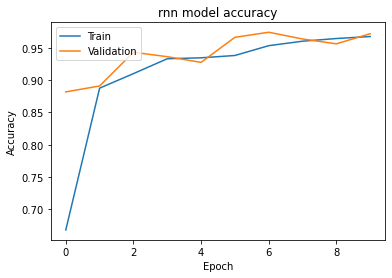

Training cnn model...
Epoch 1/10
383/383 [==============================] - 38s 94ms/step - loss: 0.3178 - accuracy: 0.6990 - val_loss: 0.1611 - val_accuracy: 0.8805
Epoch 2/10
383/383 [==============================] - 36s 93ms/step - loss: 0.1264 - accuracy: 0.9070 - val_loss: 0.0963 - val_accuracy: 0.9380
Epoch 3/10
383/383 [==============================] - 36s 93ms/step - loss: 0.0891 - accuracy: 0.9367 - val_loss: 0.0569 - val_accuracy: 0.9602
Epoch 4/10
383/383 [==============================] - 37s 96ms/step - loss: 0.0650 - accuracy: 0.9549 - val_loss: 0.0407 - val_accuracy: 0.9745
Epoch 5/10
383/383 [==============================] - 37s 95ms/step - loss: 0.0537 - accuracy: 0.9622 - val_loss: 0.0327 - val_accuracy: 0.9749
Epoch 6/10
383/383 [==============================] - 37s 96ms/step - loss: 0.0378 - accuracy: 0.9744 - val_loss: 0.0172 - val_accuracy: 0.9892
Epoch 7/10
383/383 [==============================] - 37s 96ms/step - loss: 0.0311 - accuracy: 0.9796 - val_loss: 

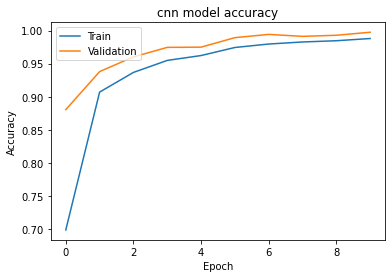

Training lstm model...
Epoch 1/10
383/383 [==============================] - 109s 269ms/step - loss: 0.3350 - accuracy: 0.6934 - val_loss: 0.1579 - val_accuracy: 0.8858
Epoch 2/10
383/383 [==============================] - 96s 250ms/step - loss: 0.1510 - accuracy: 0.8899 - val_loss: 0.0874 - val_accuracy: 0.9422
Epoch 3/10
383/383 [==============================] - 87s 227ms/step - loss: 0.1158 - accuracy: 0.9195 - val_loss: 0.0950 - val_accuracy: 0.9240
Epoch 4/10
383/383 [==============================] - 79s 206ms/step - loss: 0.0947 - accuracy: 0.9346 - val_loss: 0.0576 - val_accuracy: 0.9556
Epoch 5/10
383/383 [==============================] - 79s 207ms/step - loss: 0.0823 - accuracy: 0.9450 - val_loss: 0.0651 - val_accuracy: 0.9553
Epoch 6/10
383/383 [==============================] - 79s 208ms/step - loss: 0.0709 - accuracy: 0.9536 - val_loss: 0.0553 - val_accuracy: 0.9634
Epoch 7/10
383/383 [==============================] - 81s 212ms/step - loss: 0.0641 - accuracy: 0.9567 - v

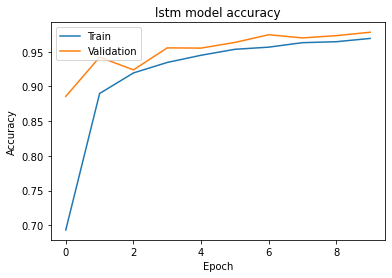

Training bilstm model...
Epoch 1/10
383/383 [==============================] - 108s 270ms/step - loss: 0.3038 - accuracy: 0.7232 - val_loss: 0.1335 - val_accuracy: 0.9044
Epoch 2/10
383/383 [==============================] - 104s 272ms/step - loss: 0.1340 - accuracy: 0.8991 - val_loss: 0.0792 - val_accuracy: 0.9488
Epoch 3/10
383/383 [==============================] - 103s 268ms/step - loss: 0.1027 - accuracy: 0.9253 - val_loss: 0.0634 - val_accuracy: 0.9576
Epoch 4/10
383/383 [==============================] - 106s 278ms/step - loss: 0.0864 - accuracy: 0.9395 - val_loss: 0.0658 - val_accuracy: 0.9563
Epoch 5/10
383/383 [==============================] - 107s 279ms/step - loss: 0.0748 - accuracy: 0.9468 - val_loss: 0.0692 - val_accuracy: 0.9566
Epoch 6/10
383/383 [==============================] - 103s 269ms/step - loss: 0.0654 - accuracy: 0.9539 - val_loss: 0.0425 - val_accuracy: 0.9788
Epoch 7/10
383/383 [==============================] - 103s 270ms/step - loss: 0.0588 - accuracy: 0.

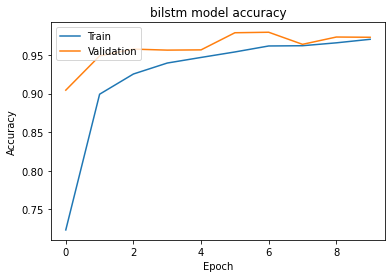

In [23]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [24]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)




#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

## DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (UNDERSAMPLED)

In [25]:
def create_rnn(num_words=50000, embedding_dim=50, rnn_units=64, dense_size=32, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=64, kernel_size=5, pool_size=2, dense_size=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=64, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
132/132 [==============================] - 11s 73ms/step - loss: 0.5511 - accuracy: 0.3625 - val_loss: 0.7457 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 9s 70ms/step - loss: 0.4348 - accuracy: 0.6080 - val_loss: 0.9159 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 9s 69ms/step - loss: 0.2934 - accuracy: 0.7751 - val_loss: 0.7256 - val_accuracy: 0.1056
Epoch 4/10
132/132 [==============================] - 10s 72ms/step - loss: 0.2198 - accuracy: 0.8367 - val_loss: 0.5330 - val_accuracy: 0.5433
Epoch 5/10
132/132 [==============================] - 10s 72ms/step - loss: 0.1736 - accuracy: 0.8831 - val_loss: 0.4247 - val_accuracy: 0.6613
Epoch 6/10
132/132 [==============================] - 10s 74ms/step - loss: 0.1411 - accuracy: 0.9053 - val_loss: 0.3248 - val_accuracy: 0.7488
Epoch 7/10
132/132 [==============================] - 10s 72ms/step - loss: 0.1224 - accuracy: 0.9191 - val_

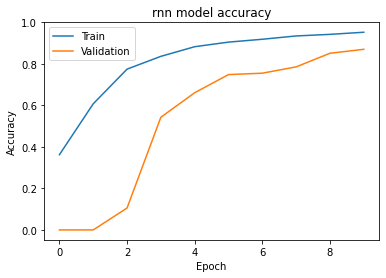

Training cnn model...
Epoch 1/10
132/132 [==============================] - 9s 64ms/step - loss: 0.4778 - accuracy: 0.4899 - val_loss: 0.9044 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 8s 60ms/step - loss: 0.2987 - accuracy: 0.7622 - val_loss: 0.8537 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 8s 58ms/step - loss: 0.2116 - accuracy: 0.8286 - val_loss: 0.6971 - val_accuracy: 0.3225
Epoch 4/10
132/132 [==============================] - 8s 59ms/step - loss: 0.1384 - accuracy: 0.9026 - val_loss: 0.3818 - val_accuracy: 0.6993
Epoch 5/10
132/132 [==============================] - 8s 58ms/step - loss: 0.0963 - accuracy: 0.9333 - val_loss: 0.2889 - val_accuracy: 0.7954
Epoch 6/10
132/132 [==============================] - 8s 59ms/step - loss: 0.0719 - accuracy: 0.9519 - val_loss: 0.2670 - val_accuracy: 0.8287
Epoch 7/10
132/132 [==============================] - 8s 59ms/step - loss: 0.0577 - accuracy: 0.9624 - val_loss:

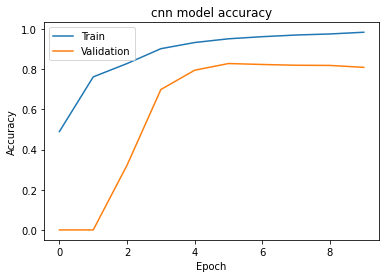

Training lstm model...
Epoch 1/10
132/132 [==============================] - 31s 209ms/step - loss: 0.4624 - accuracy: 0.5270 - val_loss: 0.8531 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 28s 210ms/step - loss: 0.2664 - accuracy: 0.7798 - val_loss: 0.7647 - val_accuracy: 0.0894
Epoch 3/10
132/132 [==============================] - 28s 216ms/step - loss: 0.1825 - accuracy: 0.8586 - val_loss: 0.3862 - val_accuracy: 0.6955
Epoch 4/10
132/132 [==============================] - 27s 205ms/step - loss: 0.1326 - accuracy: 0.9019 - val_loss: 0.2998 - val_accuracy: 0.7869
Epoch 5/10
132/132 [==============================] - 28s 211ms/step - loss: 0.1063 - accuracy: 0.9226 - val_loss: 0.2047 - val_accuracy: 0.8601
Epoch 6/10
132/132 [==============================] - 28s 210ms/step - loss: 0.0895 - accuracy: 0.9383 - val_loss: 0.2038 - val_accuracy: 0.8658
Epoch 7/10
132/132 [==============================] - 29s 222ms/step - loss: 0.0810 - accuracy: 0.9457 

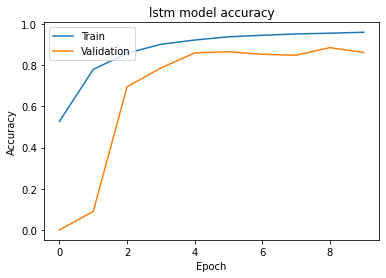

Training bilstm model...
Epoch 1/10
132/132 [==============================] - 38s 250ms/step - loss: 0.4567 - accuracy: 0.5358 - val_loss: 0.9492 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 32s 246ms/step - loss: 0.2729 - accuracy: 0.7817 - val_loss: 0.7242 - val_accuracy: 0.2293
Epoch 3/10
132/132 [==============================] - 33s 249ms/step - loss: 0.1804 - accuracy: 0.8665 - val_loss: 0.3628 - val_accuracy: 0.7755
Epoch 4/10
132/132 [==============================] - 32s 240ms/step - loss: 0.1289 - accuracy: 0.9060 - val_loss: 0.2795 - val_accuracy: 0.8316
Epoch 5/10
132/132 [==============================] - 33s 251ms/step - loss: 0.1132 - accuracy: 0.9153 - val_loss: 0.1804 - val_accuracy: 0.8858
Epoch 6/10
132/132 [==============================] - 32s 245ms/step - loss: 0.0928 - accuracy: 0.9331 - val_loss: 0.2225 - val_accuracy: 0.8649
Epoch 7/10
132/132 [==============================] - 33s 247ms/step - loss: 0.0806 - accuracy: 0.941

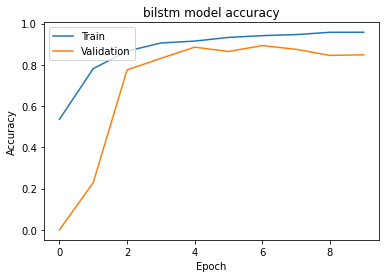

In [26]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()